In [1]:
import torch
import torchvision
from torchvision import datasets
from torch import nn, optim, autograd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import KFold

#from google.colab import drive

import itertools
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
import sys    

In [2]:
#drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [2]:
# needed to import external py modules
path_py_modules = os.path.join(os.getcwd(), '../py_modules')
sys.path.append(path_py_modules) 

In [3]:
from models import MLP, CNN, CNN3
from datasets import CustomDatasetCFMNIST, inject_ColorBias, generate_CMNIST
from model_utils import train_reference, test_reference, train_subgroup, test_subgroup, train_subgroup_noadv, DemographicParityGap, EqualizedOddsGap, n_runs_subgroupAdvTrain_v2, n_runs_subgroupNoAdv
from utils import examples_CMNIST, display_confs, plot_subgroup_losses, plot_hist_subgroups, plot_loss_noadv

# Biased dataset

Class 0
  Number of samples: tensor(6000)
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Colors: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
  Agreement colors/labels (accross the whole class): 95.217%


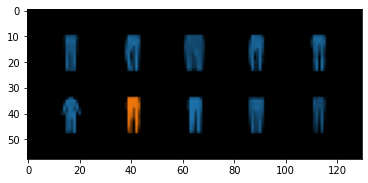

Class 1
  Number of samples: tensor(6000)
  Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Colors: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Agreement colors/labels (accross the whole class): 95.350%


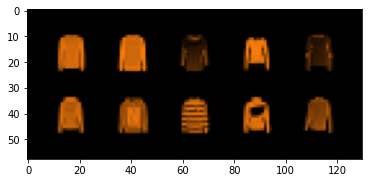

In [6]:
tr_data = generate_CMNIST(train=True, main_color_prop=0.95, class_colors=[0,1], downsample=True, classes=[1,2], dataset='fashion mnist')
examples_CMNIST(tr_data)

Class 0
  Number of samples: tensor(1000)
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Colors: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
  Agreement colors/labels (accross the whole class): 9.500%


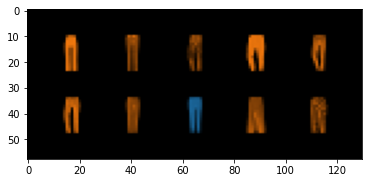

Class 1
  Number of samples: tensor(1000)
  Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Colors: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
  Agreement colors/labels (accross the whole class): 10.400%


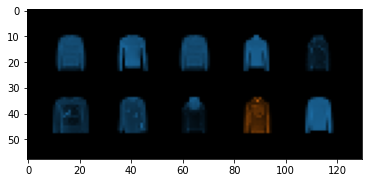

In [7]:
te_data = generate_CMNIST(train=False, main_color_prop=0.1, class_colors=[0,1], downsample=True, classes=[1,2],  dataset='fashion mnist')
examples_CMNIST(te_data)

# Reduced CFashionMNIST: 2 classes (digits), 2 subgroups (colors)

## Train reference classifier with ERM

In [8]:
BATCH_SIZE = 4096 
cfmnist_tr = CustomDatasetCFMNIST(train=True, main_color_prop=0.95, class_colors=[0,1], classes=[1,2]) # [0,2] ok
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 
cfmnist_te = CustomDatasetCFMNIST(train=False, main_color_prop=0.1, class_colors=[0,1], classes=[1,2], means=cfmnist_tr.means, stds=cfmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cfmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=2).to(device)

# cross entropy loss, SGD
# optimizer_ref = optim.Adam(ref_clf.parameters(), lr=0.1) # more robust to bias
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.1)
n_epochs = 2

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=0.50811
Epoch 1: loss=0.20560


Average accuracy: 0.95100


accuracy
label subgroup          
0     0         1.000000
      1         0.046931
1     0         0.000000
      1         0.997890

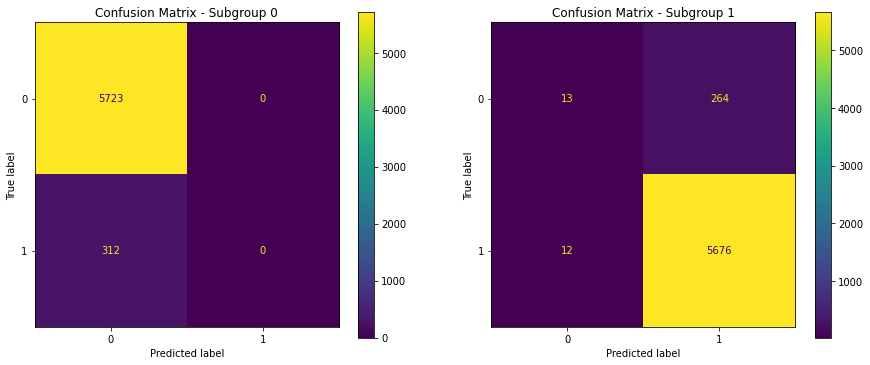

In [10]:
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Average accuracy: 0.12100


accuracy
label subgroup          
0     0         1.000000
      1         0.048458
1     0         0.001117
      1         1.000000

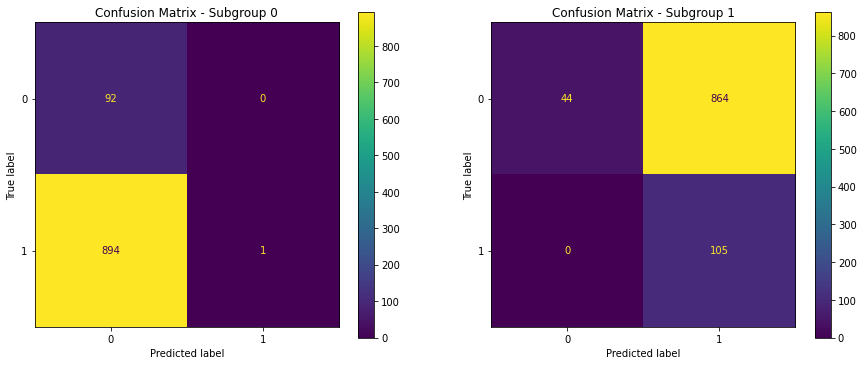

In [11]:
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

In [14]:
# check demographic parity gap for true subgroups
num_classes=2
num_subgroups=2
out = nn.functional.one_hot(cfmnist_tr.subgroup).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.9916],
        [0.9916]])


tensor(0.9916)

In [16]:
# check demographic parity gap for subgroups based on bp
num_classes=2
num_subgroups=2
out = nn.functional.one_hot(cfmnist_tr.biased_predictions.long()).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1.],
        [1.]])


tensor(1.)

## Subgroup label prediction

Based only on demographic parity gap.

In [12]:
# get biased preds 
# funk it
for i in range(cfmnist_tr.__len__()):
   _, img, _, _, _ = cfmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cfmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [ ]:
#without adversary+MI 
model = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=2)
results = n_runs_subgroupNoAdv(n_runs=10, n_epochs=20, num_classes=2, num_subgroups=2, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te,
                               lr=0.01, loss_fn=DemographicParityGap(), train_loader=train_loader, test_loader=test_loader, 
                               device=device, model=model)

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 5--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 6--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogene

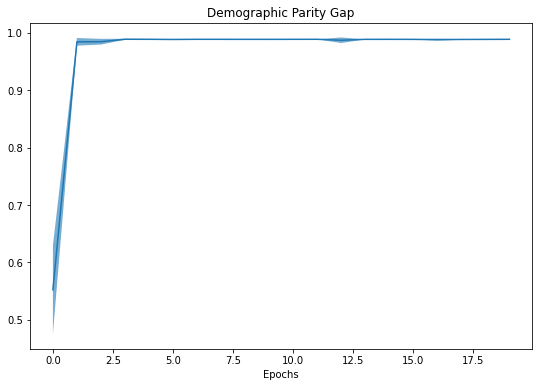

In [ ]:
plot_loss_noadv(results['epoch_loss'], 'Demographic Parity Gap')

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.906977
1     0                 1.000000
      1                 0.998771

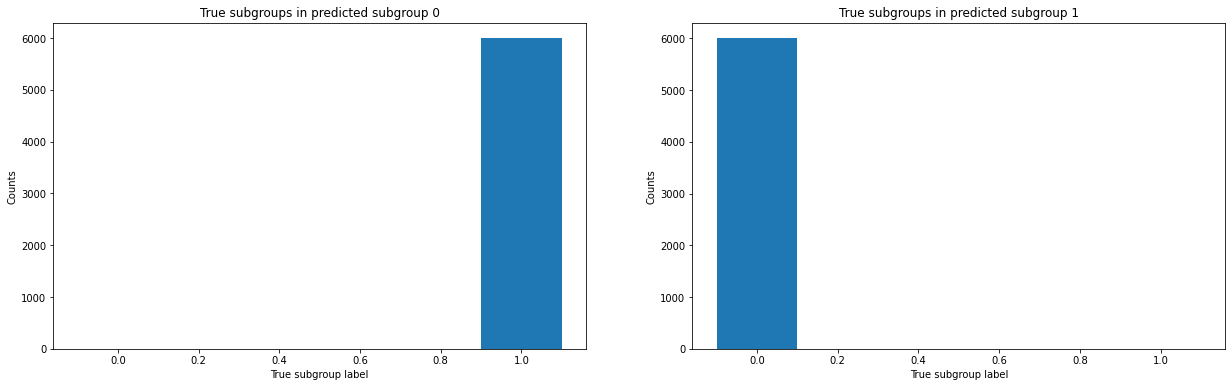

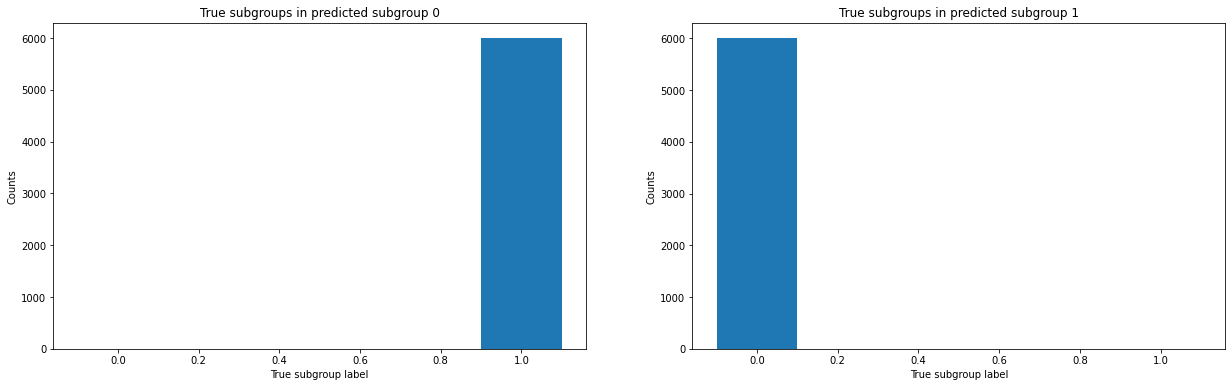

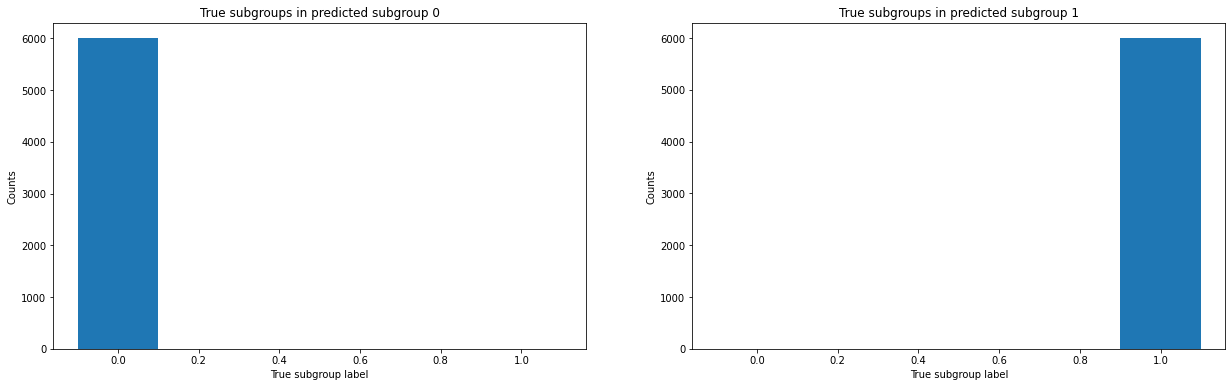

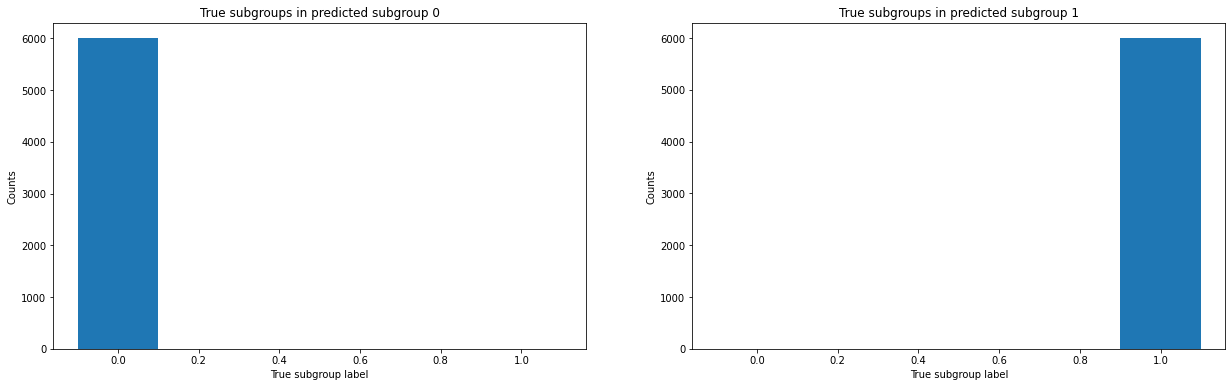

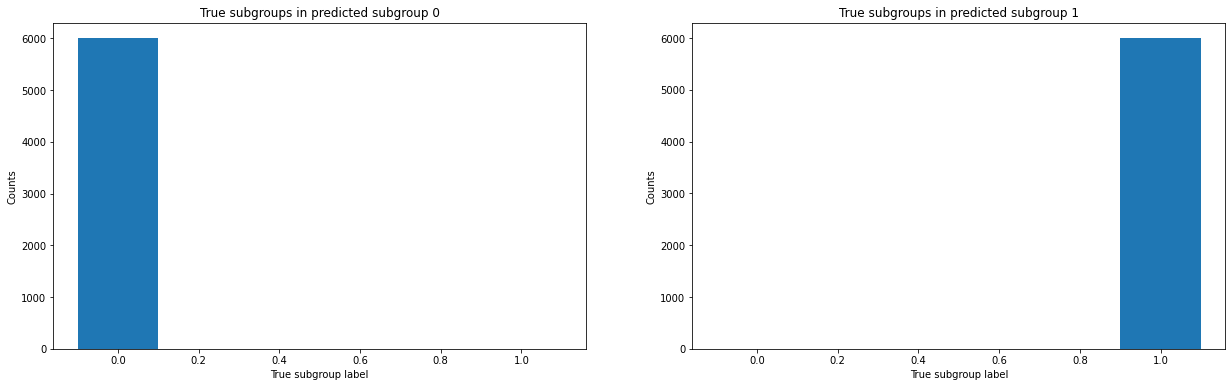

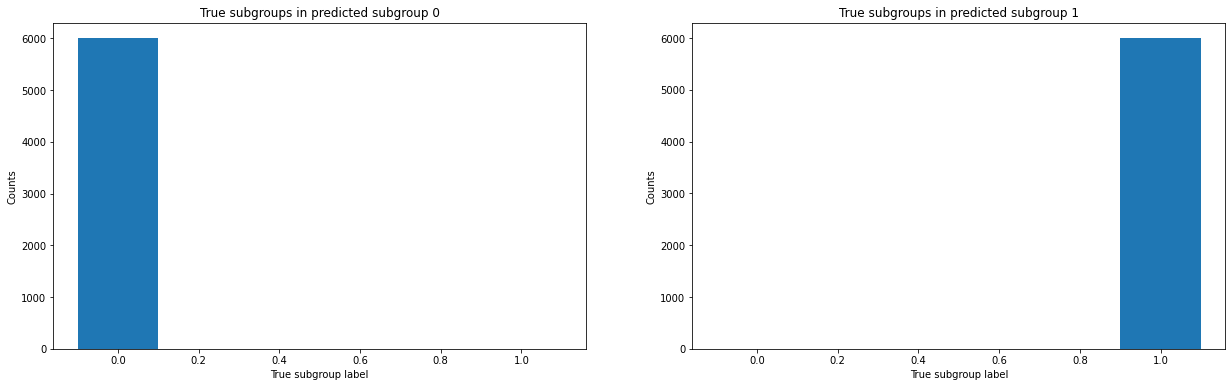

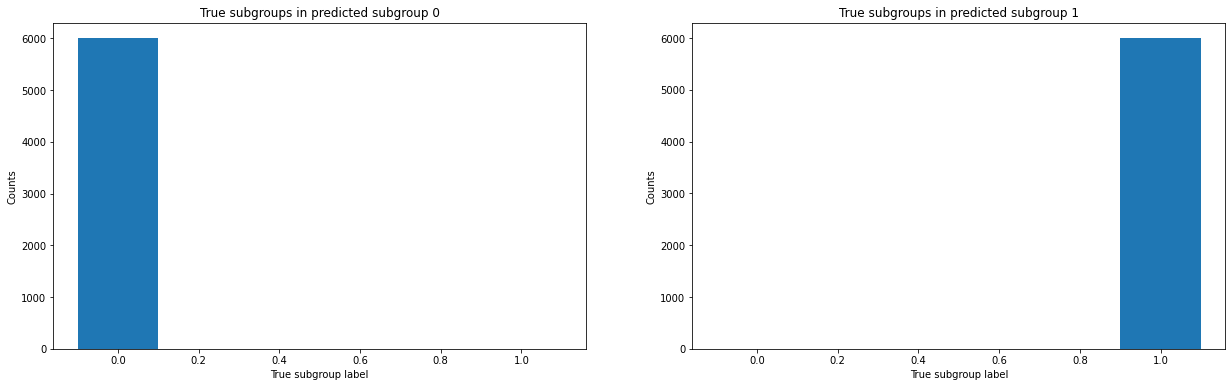

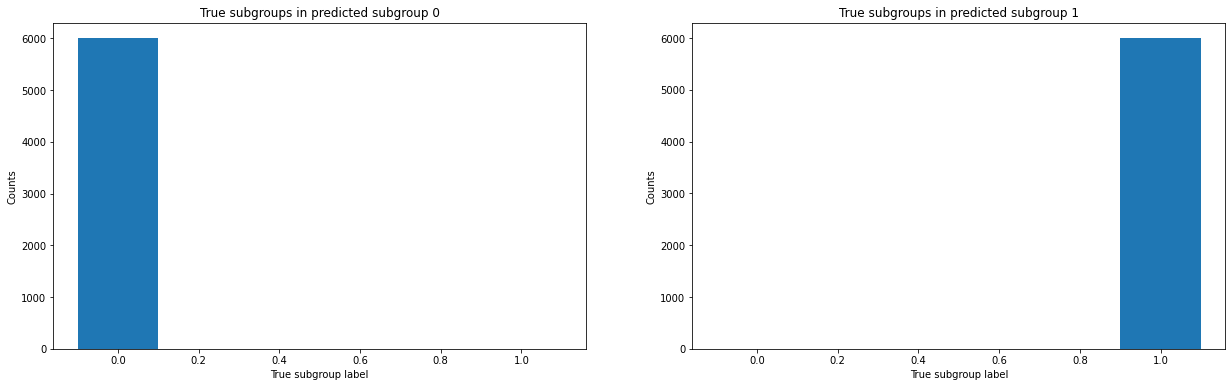

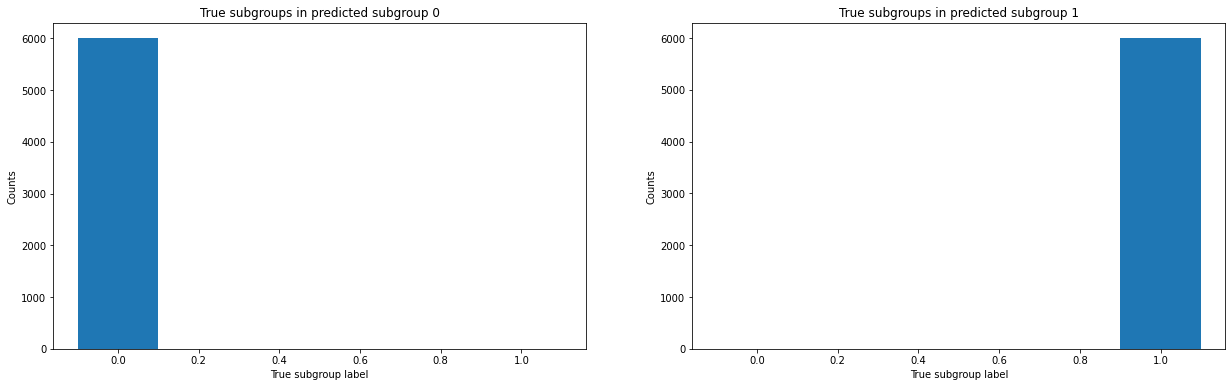

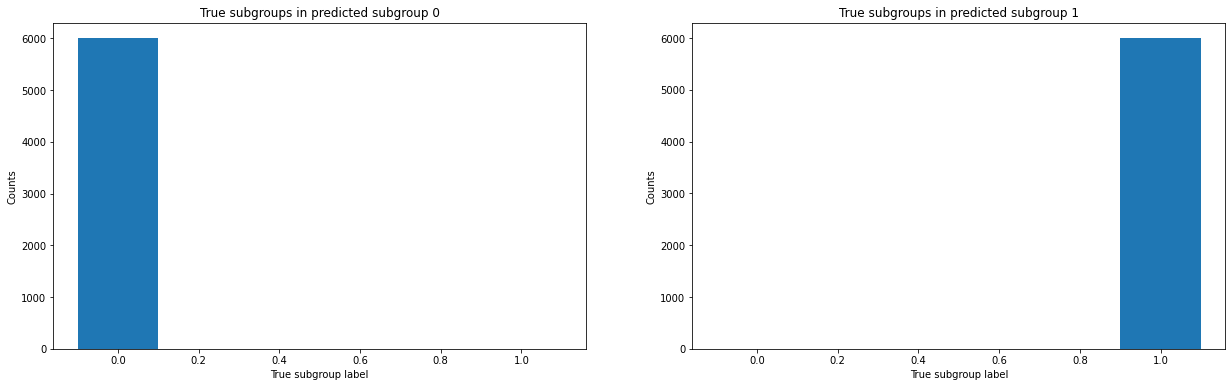

In [ ]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cfmnist_tr, indices=results['idx_tr'], 
                    probs=results['probs_tr'], check_bp=True)

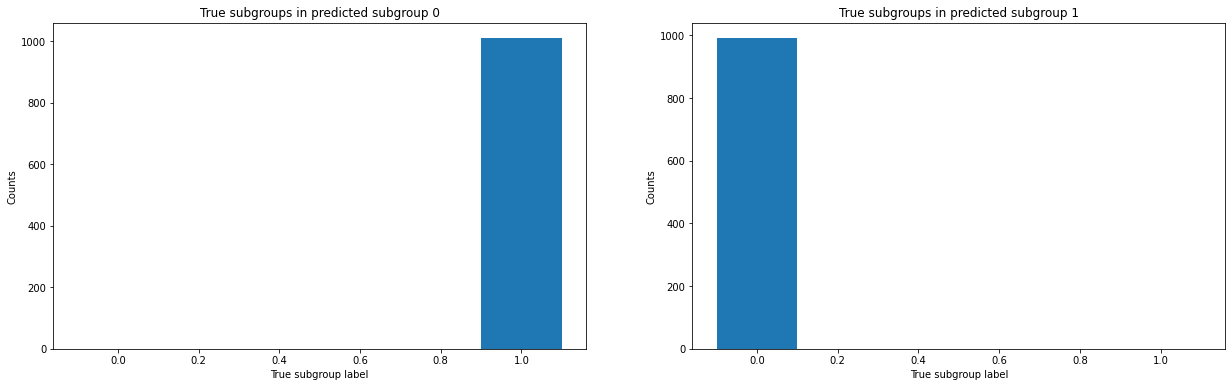

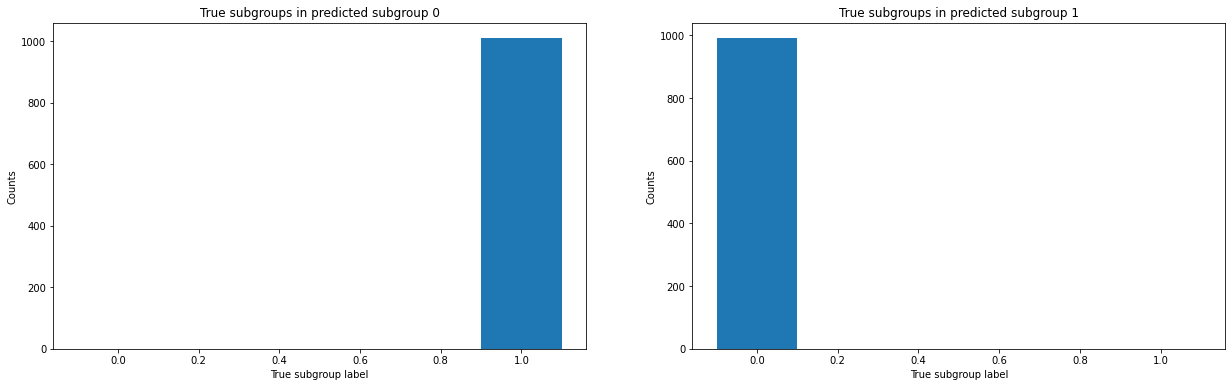

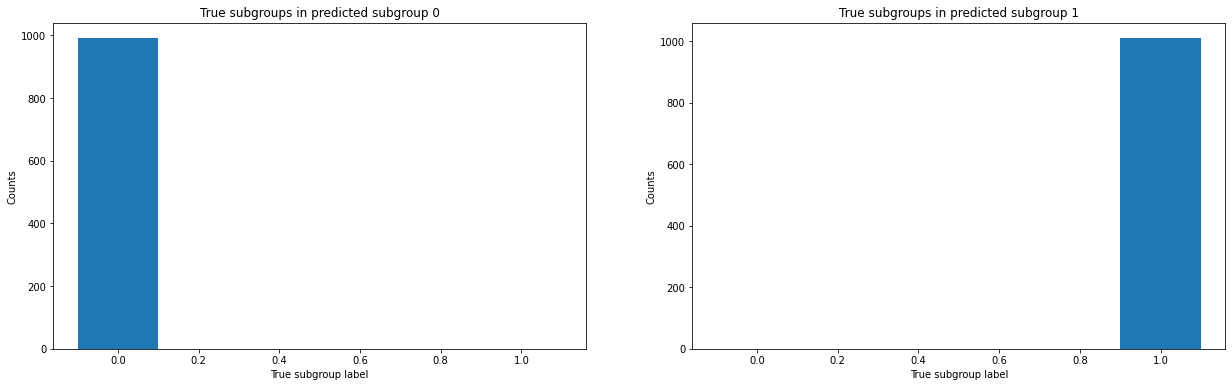

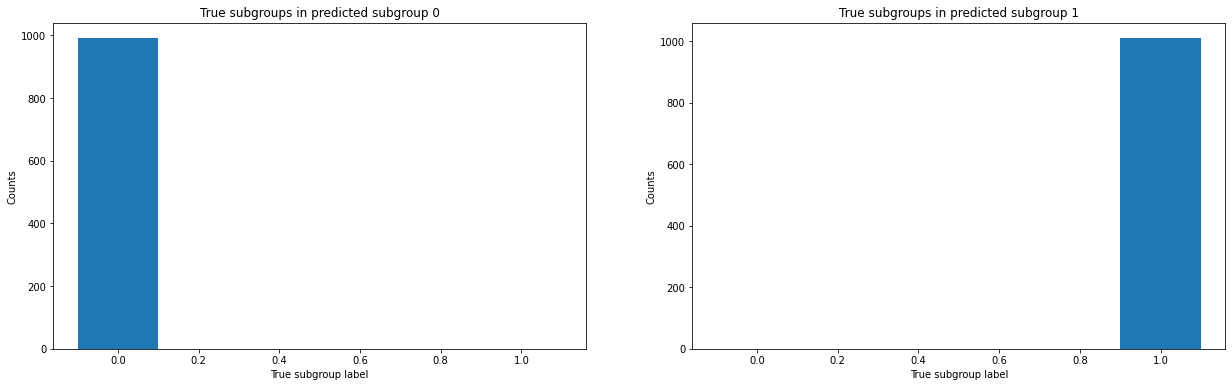

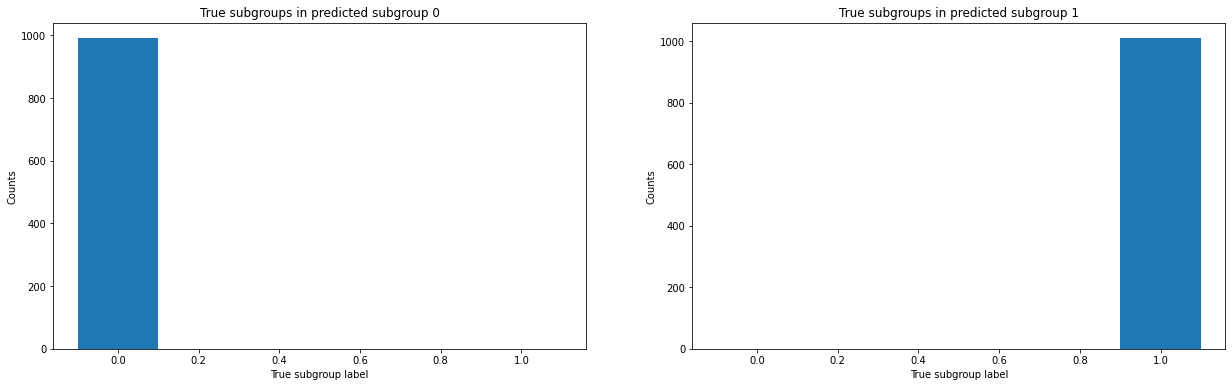

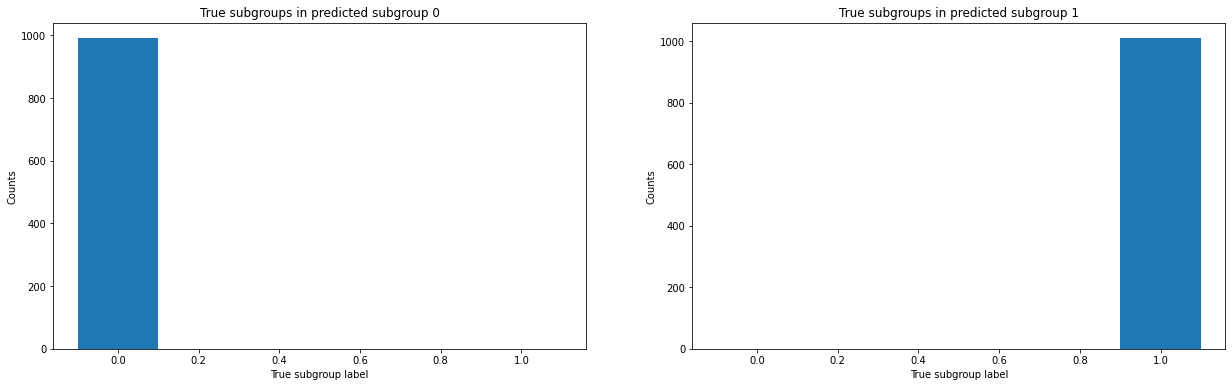

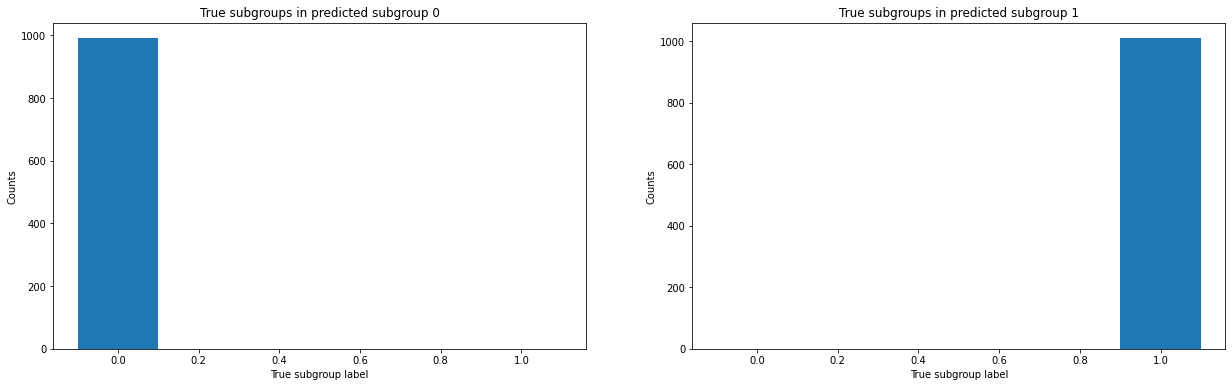

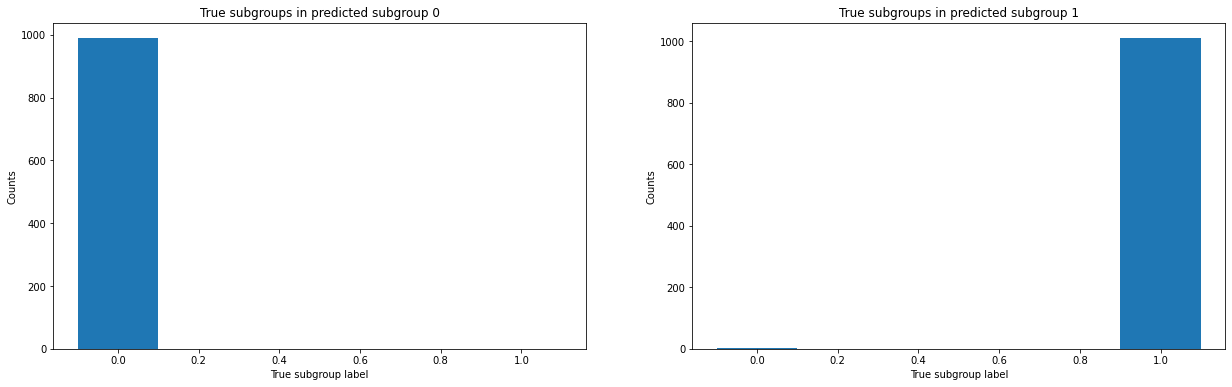

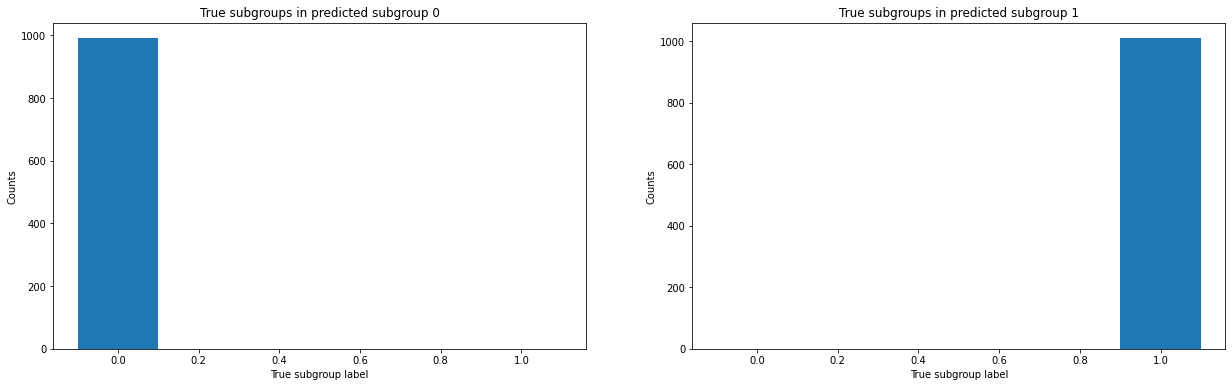

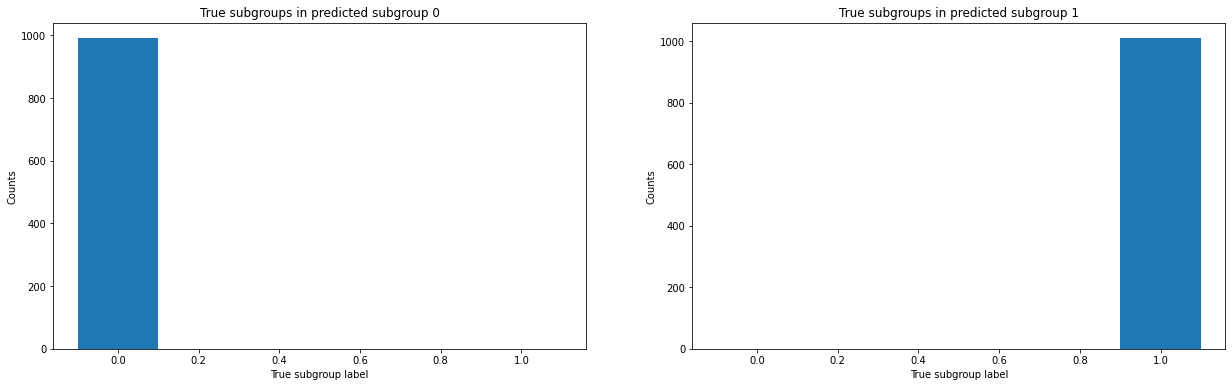

In [ ]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cfmnist_te, indices=results['idx_te'], 
                    probs=results['probs_te'], check_bp=False)

## Subgroup label prediction with MI regularizer

In [13]:
# more epochs allow to get adv acc closer to 0.5 ? ok but not always
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=2)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=2)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=25, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te, device=device, 
                                     num_classes=2, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=DemographicParityGap(), loss_fn_adv=nn.CrossEntropyLoss(), 
                                     lr=0.01, lr_adv=0.001, mi_weight=1., verbose=False, same_weight_init=False, l2_reg=0, anomaly_detection=False) 

--------Run 0--------
Train homogeneity score: 0.991 ; Train completeness score: 0.991
Test homogeneity score: 0.985 ; Test completeness score: 0.985
Adversary train accuracy (target=biased predictions): 0.99367
--------Run 1--------
Train homogeneity score: 0.999 ; Train completeness score: 0.999
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99358
--------Run 2--------
Train homogeneity score: 0.983 ; Train completeness score: 0.983
Test homogeneity score: 0.960 ; Test completeness score: 0.960
Adversary train accuracy (target=biased predictions): 0.99675
--------Run 3--------
Train homogeneity score: 0.992 ; Train completeness score: 0.992
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99817
--------Run 4--------
Train homogeneity score: 0.991 ; Train completeness score: 0.991
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Ad

In [18]:
with open('../results/cfmnist_2_2_dpg.pkl', 'wb') as f:
  pkl.dump(results, f)

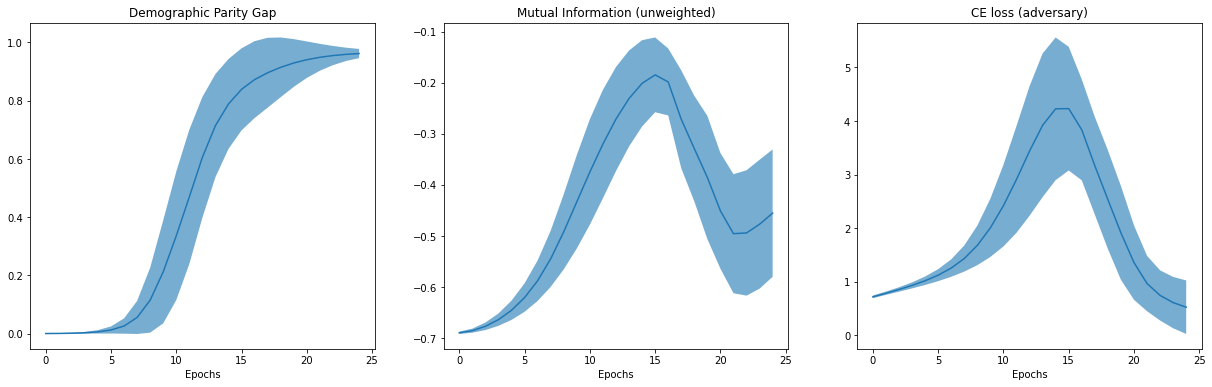

In [17]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'])

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.999297

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998066

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.963899
1     0                 1.000000
      1                 0.998418

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998769

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998945

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.997363

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998594

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.971119
1     0                 1.000000
      1                 0.991385

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998594

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.953069
1     0                 1.000000
      1                 0.998594

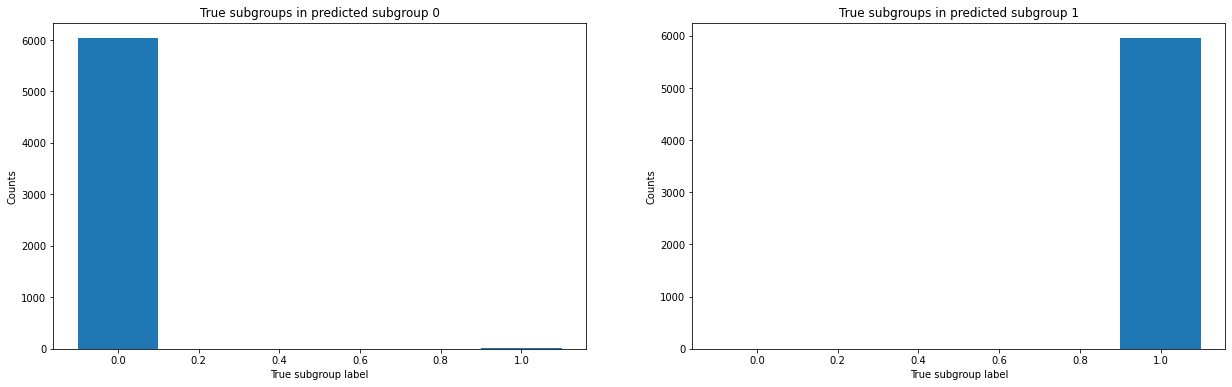

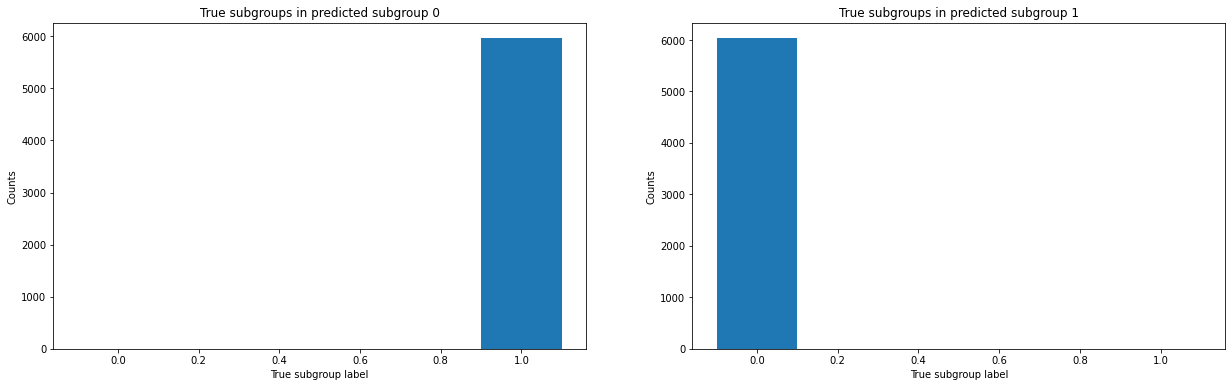

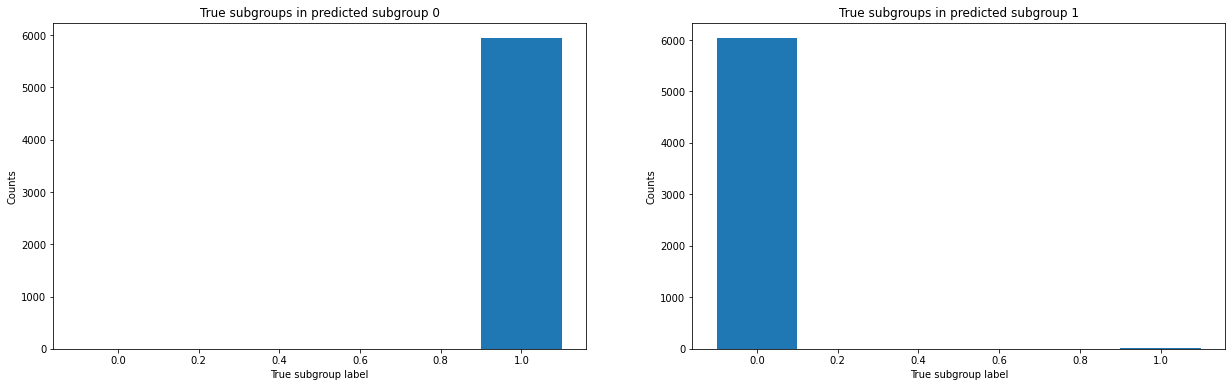

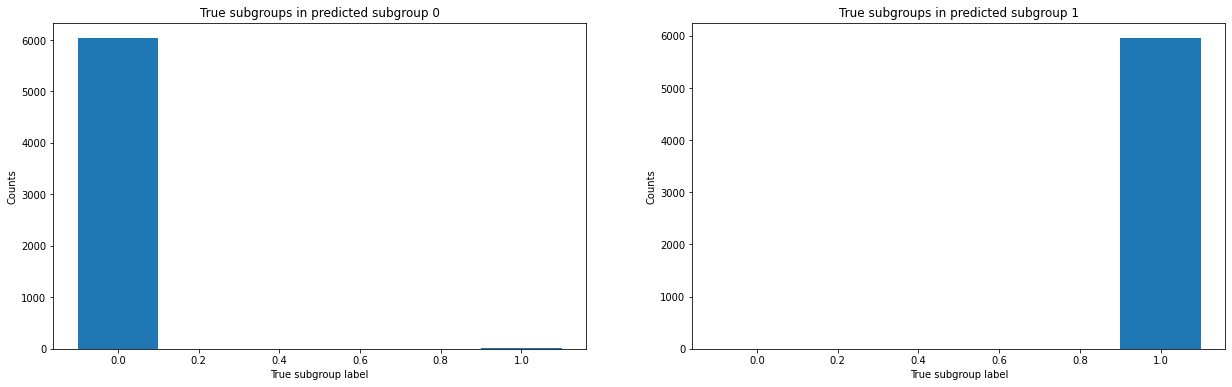

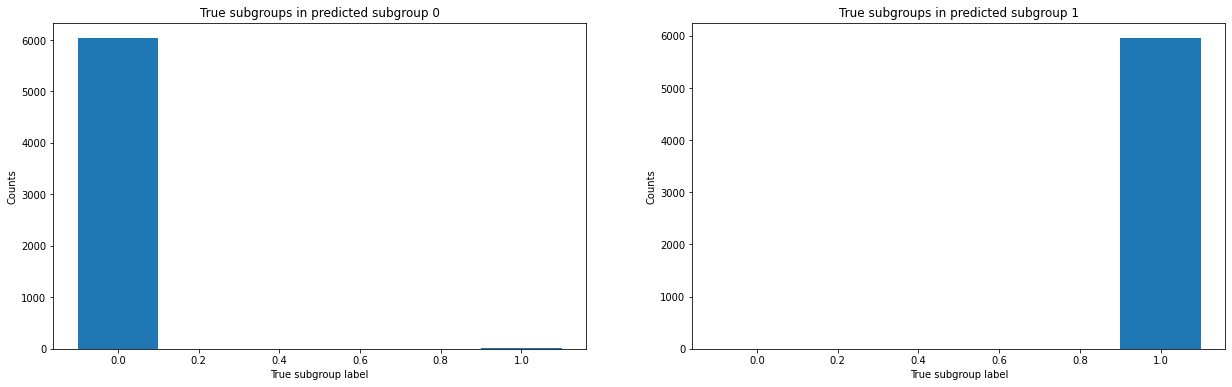

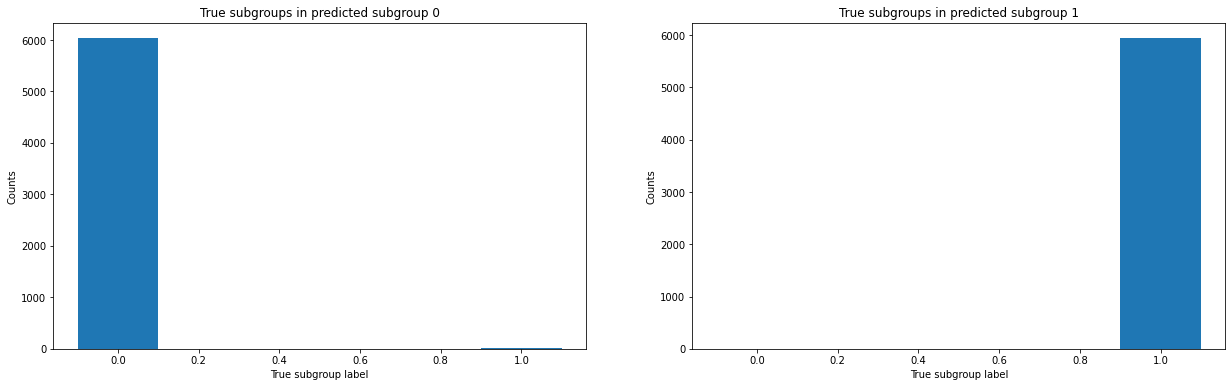

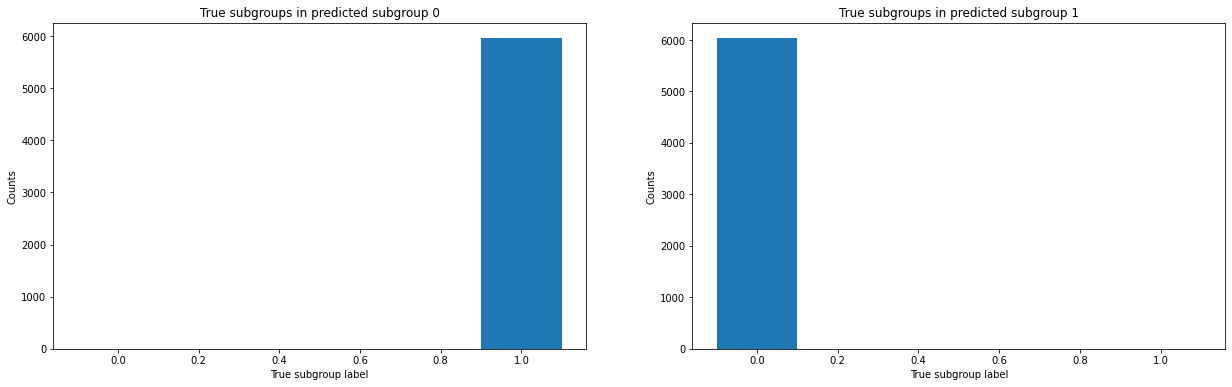

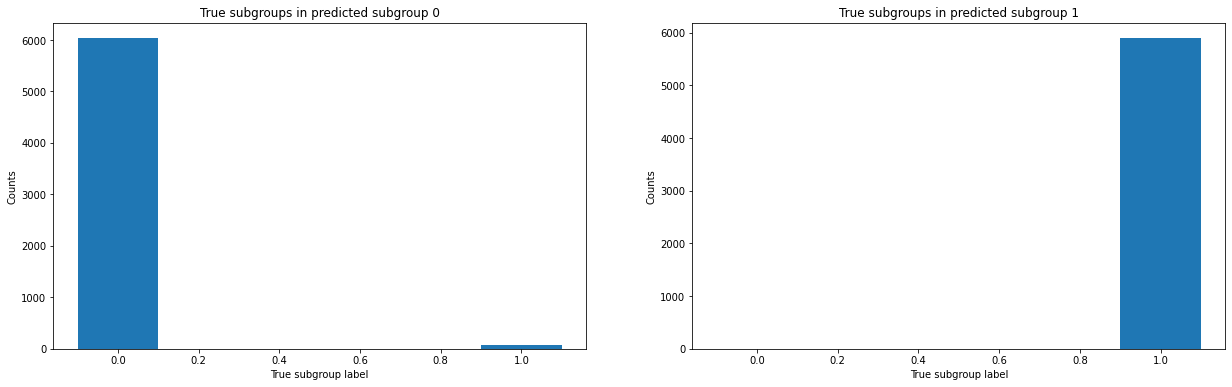

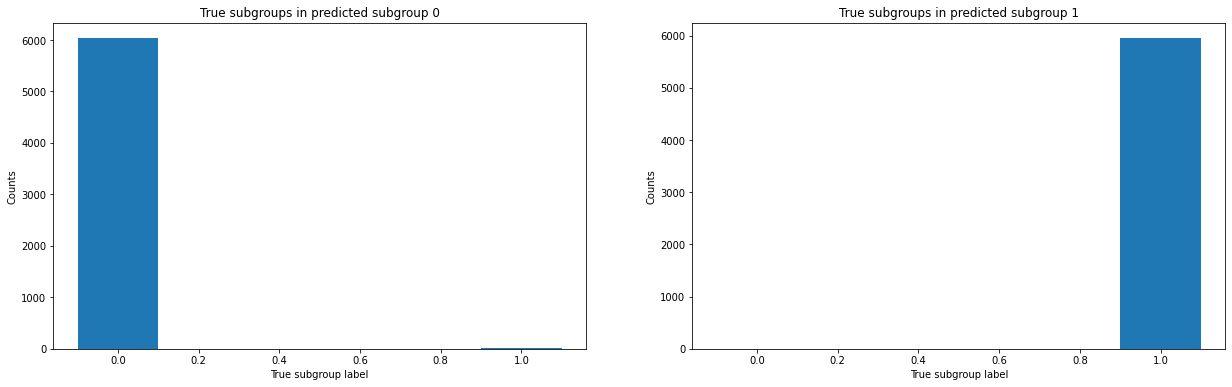

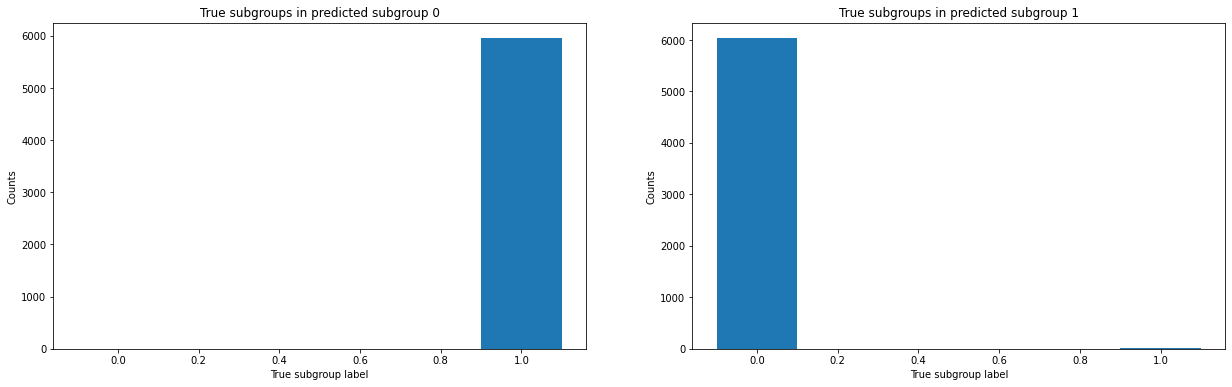

In [19]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cfmnist_tr, indices=results['idx_tr'], 
                    probs=results['probs_tr'], check_bp=True)

In [21]:
# test with Eq. Odds - works too, but also seems less stable than dpg + needs more epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=2)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=2)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=40, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te, device=device, 
                                     num_classes=2, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=EqualizedOddsGap(), loss_fn_adv=nn.CrossEntropyLoss(), 
                                     lr=0.01, lr_adv=0.001, mi_weight=1., verbose=False, same_weight_init=False, l2_reg=0, anomaly_detection=False) 

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99792
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99792
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99792
--------Run 3--------
Train homogeneity score: 0.775 ; Train completeness score: 0.780
Test homogeneity score: 0.096 ; Test completeness score: 0.218
Adversary train accuracy (target=biased predictions): 0.96600
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Ad

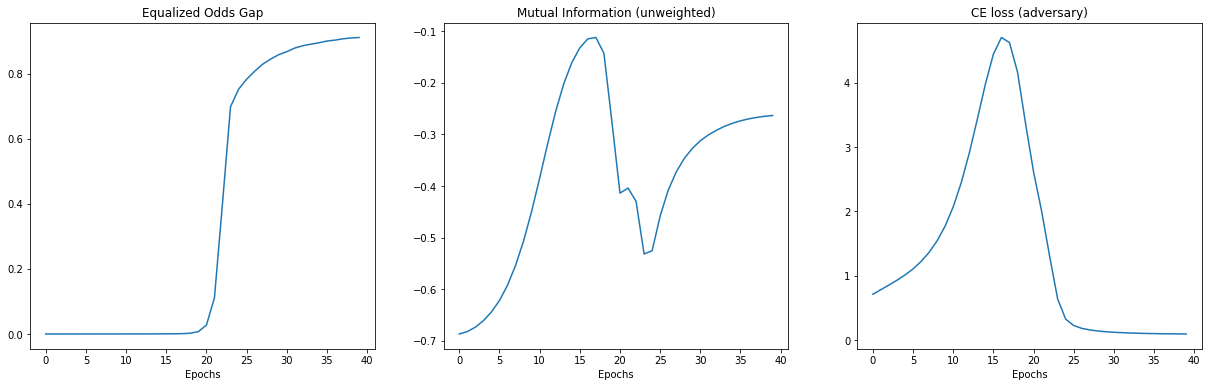

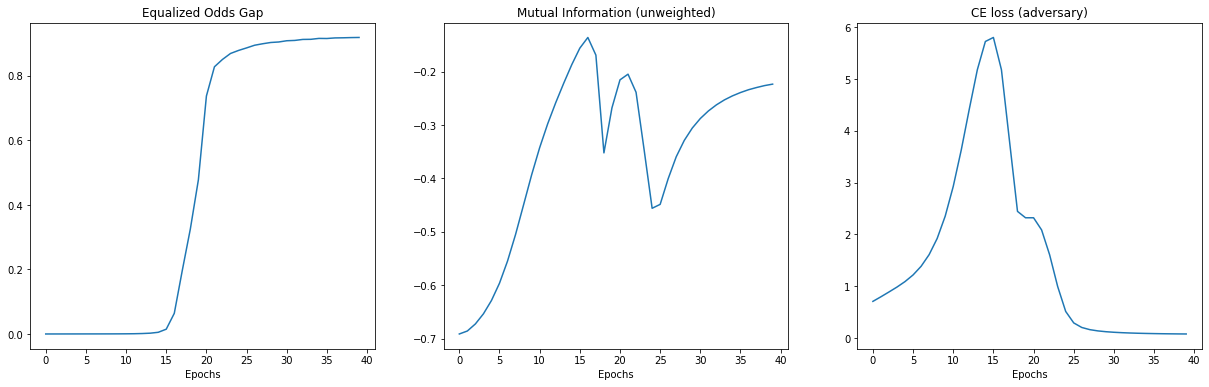

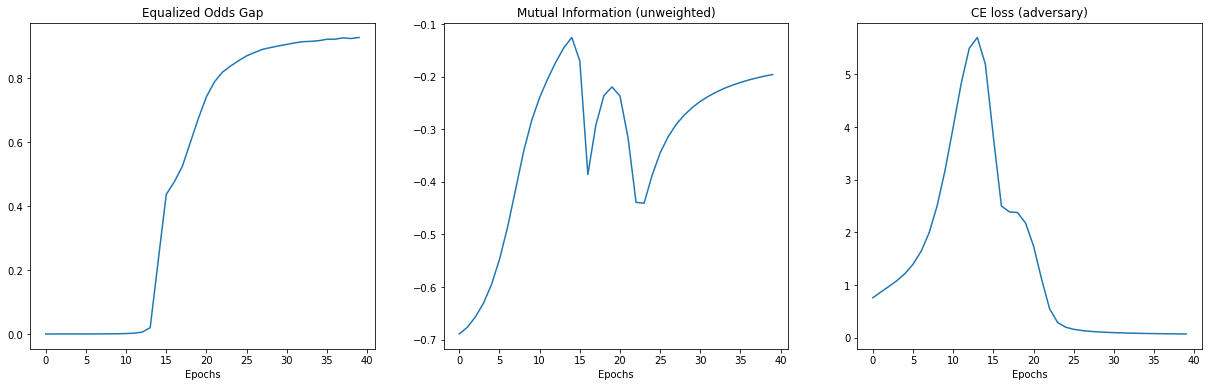

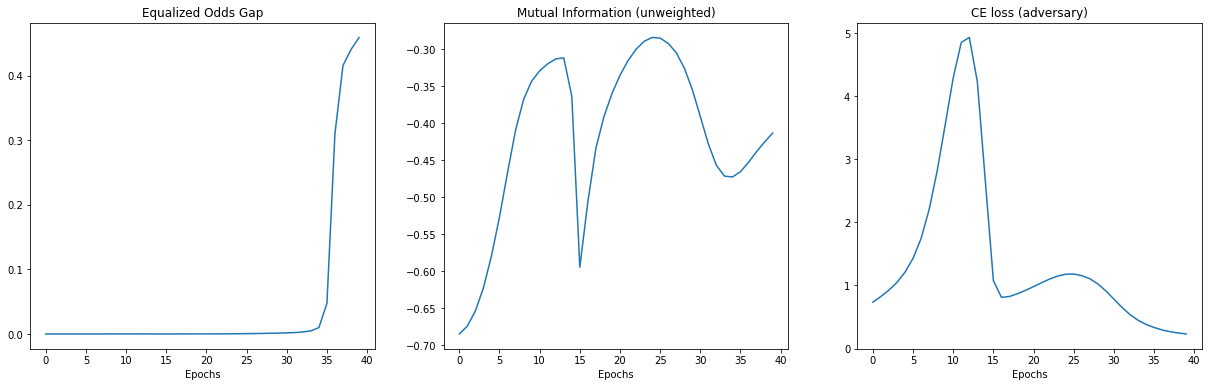

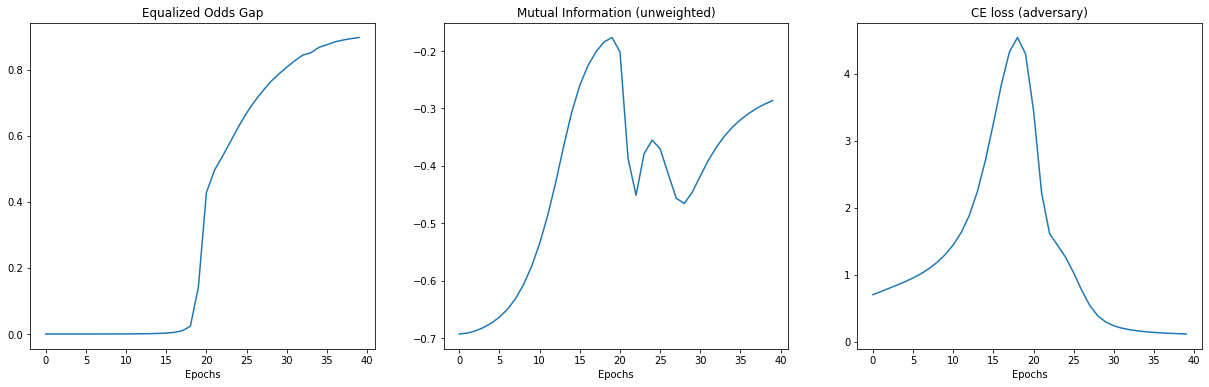

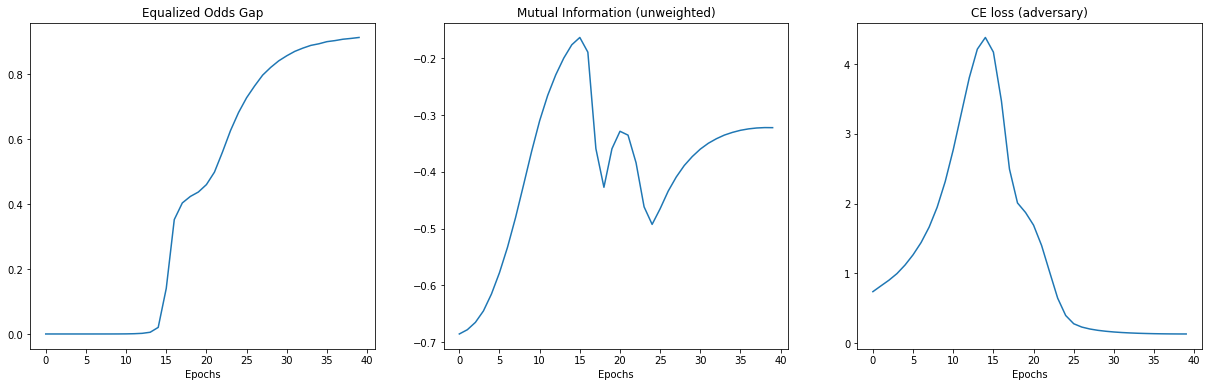

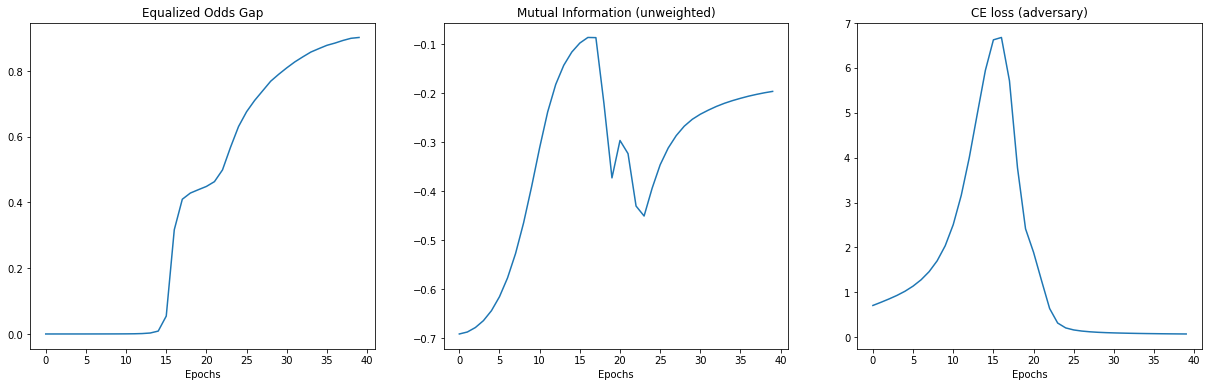

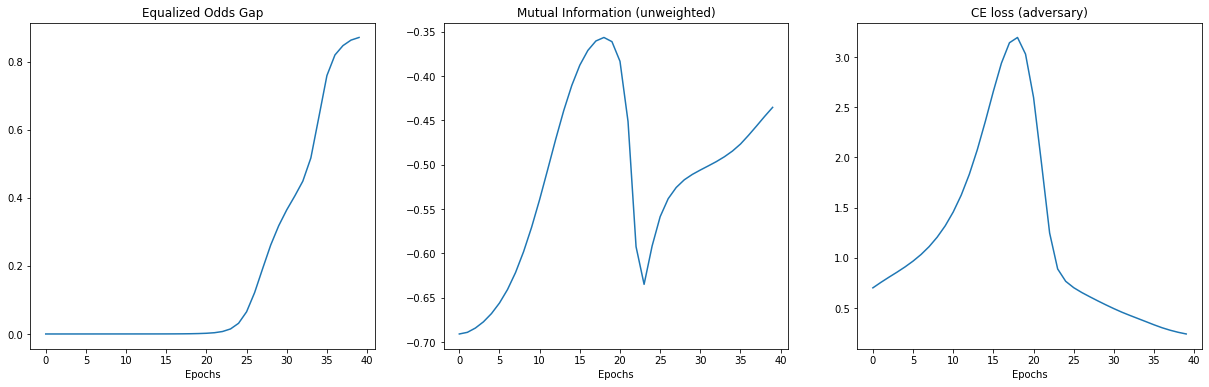

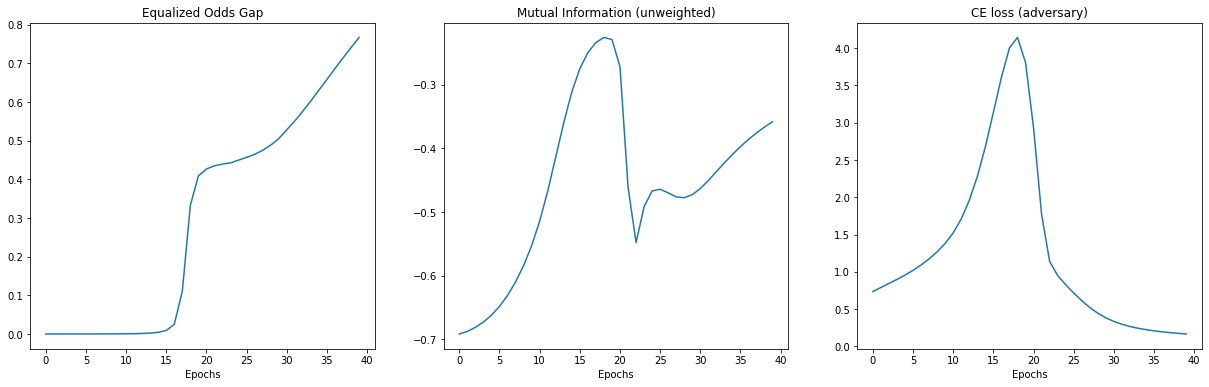

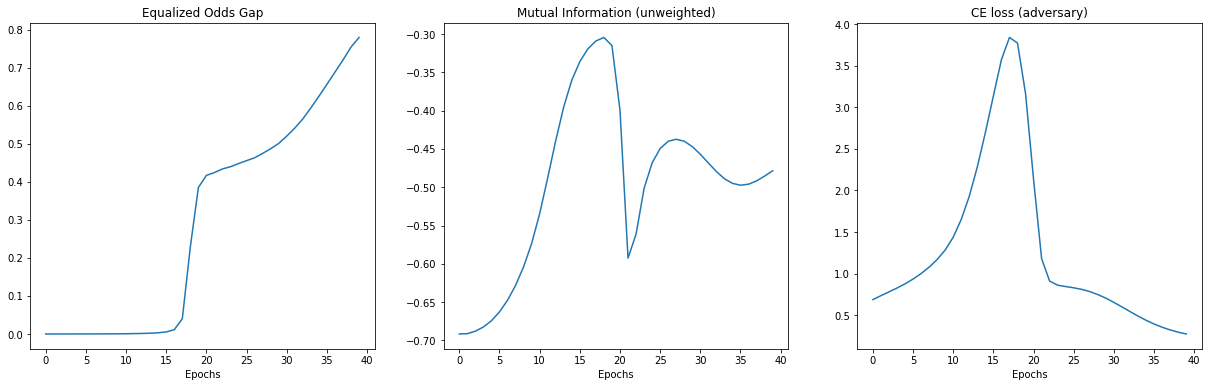

In [23]:
for i in range(10):
  plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[i], loss_name='Equalized Odds Gap')

# Reduced CMNIST: 3 classes (digits), 3 subgroups (colors)

In [43]:
BATCH_SIZE = 4096 
cfmnist_tr = CustomDatasetCFMNIST(train=True, main_color_prop=0.9, class_colors=[0,1,2], classes=[0,2,6])
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 
cfmnist_te = CustomDatasetCFMNIST(train=False, main_color_prop=0.1, class_colors=[0,1,2], classes=[0,2,6], means=cfmnist_tr.means, stds=cfmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cfmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=3).to(device)
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.1)
n_epochs = 4

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=0.86733
Epoch 3: loss=0.34367


Train set
Average accuracy: 0.89883


accuracy
label subgroup          
0     0         0.997235
      1         0.003344
      2         0.000000
1     0         0.000000
      1         0.994234
      2         0.000000
2     0         0.063898
      1         0.030717
      2         1.000000

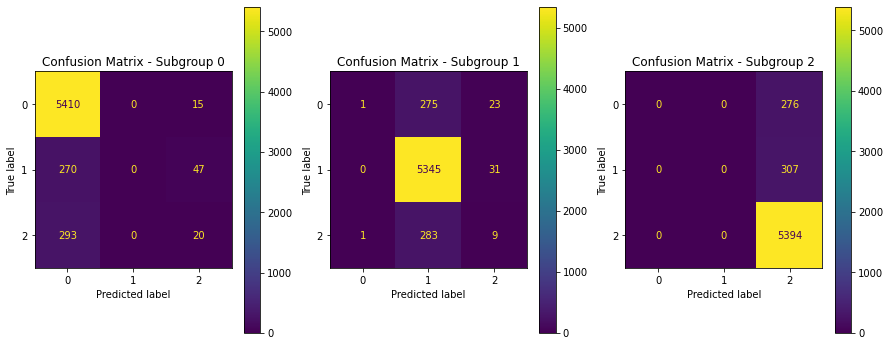

In [47]:
print('Train set')
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Test set
Average accuracy: 0.11533


accuracy
label subgroup          
0     0         0.968750
      1         0.000000
      2         0.000000
1     0         0.000000
      1         1.000000
      2         0.000000
2     0         0.100457
      1         0.026030
      2         1.000000

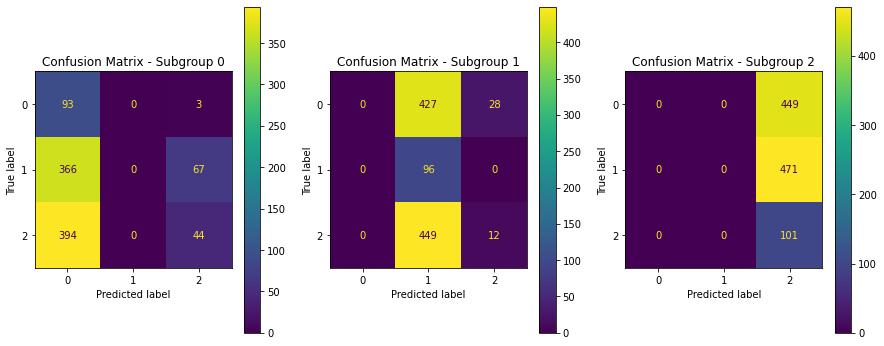

In [48]:
print('Test set')
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

In [49]:
# get biased preds -
# funk it
for i in range(cfmnist_tr.__len__()):
   _, img, _, _, _ = cfmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cfmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [50]:
# check demographic parity gap for true subgroups
num_classes=3
num_subgroups=3
out = nn.functional.one_hot(cfmnist_tr.subgroup).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[9.7244e-01, 9.7310e-01, 1.1231e-07],
        [9.7834e-01, 0.0000e+00, 9.7834e-01],
        [8.9175e-06, 9.7310e-01, 9.7900e-01]])


tensor(0.6505)

In [51]:
# check demographic parity gap for subgroups based on bp
num_classes=3
num_subgroups=3
out = nn.functional.one_hot(cfmnist_tr.biased_predictions.long()).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.]])


tensor(0.6667)

## Subgroup Label Prediction

In [31]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [ ]:
#without adversary+MI 
model = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=3)
results = n_runs_subgroupNoAdv(n_runs=10, n_epochs=20, num_classes=3, num_subgroups=3, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te,
                               lr=0.001, loss_fn=DemographicParityGap(), train_loader=train_loader, test_loader=test_loader, 
                               device=device, model=model)

--------Run 0--------
Train homogeneity score: 0.991 ; Train completeness score: 0.991
Test homogeneity score: 0.968 ; Test completeness score: 0.968
--------Run 1--------
Train homogeneity score: 0.991 ; Train completeness score: 0.991
Test homogeneity score: 0.968 ; Test completeness score: 0.968
--------Run 2--------
Train homogeneity score: 0.997 ; Train completeness score: 0.997
Test homogeneity score: 0.982 ; Test completeness score: 0.982
--------Run 3--------
Train homogeneity score: 0.999 ; Train completeness score: 0.999
Test homogeneity score: 0.998 ; Test completeness score: 0.998
--------Run 4--------
Train homogeneity score: 0.983 ; Train completeness score: 0.983
Test homogeneity score: 0.912 ; Test completeness score: 0.913
--------Run 5--------
Train homogeneity score: 0.990 ; Train completeness score: 0.990
Test homogeneity score: 0.966 ; Test completeness score: 0.966
--------Run 6--------
Train homogeneity score: 0.998 ; Train completeness score: 0.998
Test homogene

In [ ]:
# maximum loss reached for each run
results['epoch_loss'].max(axis=1) 

array([0.65901387, 0.65935749, 0.65978122, 0.65820527, 0.66007024,
       0.65734851, 0.65730935, 0.6568585 , 0.65777206, 0.65712476])

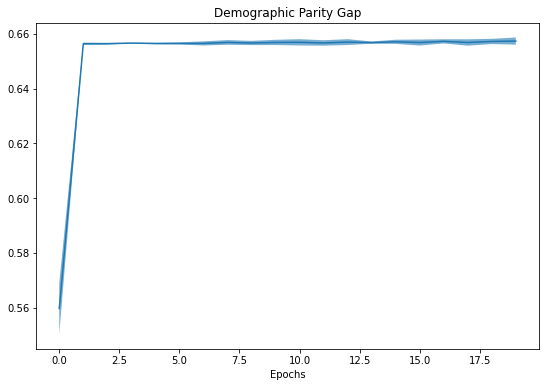

In [ ]:
plot_loss_noadv(results['epoch_loss'], title='Demographic Parity Gap')

acc_biased_preds
label subgroup                  
0     0                 0.999444
      1                 0.966997
      2                 1.000000
1     0                 0.950156
      1                 0.996477
      2                 1.000000
2     0                 0.956989
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998332
      1                 0.983498
      2                 1.000000
1     0                 0.915888
      1                 0.999073
      2                 1.000000
2     0                 0.935484
      1                 0.984709
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.999259
      1                 0.966997
      2                 1.000000
1     0                 0.915888
      1                 0.996477
      2                 1.000000
2     0                 0.942652
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998332
      1                 0.966997
      2                 1.000000
1     0                 0.915888
      1                 0.996477
      2                 1.000000
2     0                 0.935484
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.999259
      1                 0.973597
      2                 1.000000
1     0                 0.956386
      1                 0.996848
      2                 1.000000
2     0                 0.967742
      1                 0.981651
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998888
      1                 0.966997
      2                 1.000000
1     0                 0.937695
      1                 0.996477
      2                 1.000000
2     0                 0.942652
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998888
      1                 0.966997
      2                 1.000000
1     0                 0.915888
      1                 0.996477
      2                 1.000000
2     0                 0.935484
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998332
      1                 0.966997
      2                 1.000000
1     0                 0.915888
      1                 0.996477
      2                 1.000000
2     0                 0.935484
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998703
      1                 0.966997
      2                 1.000000
1     0                 0.934579
      1                 0.996477
      2                 1.000000
2     0                 0.939068
      1                 0.972477
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.998888
      1                 0.980198
      2                 1.000000
1     0                 0.915888
      1                 0.996106
      2                 1.000000
2     0                 0.935484
      1                 0.978593
      2                 1.000000

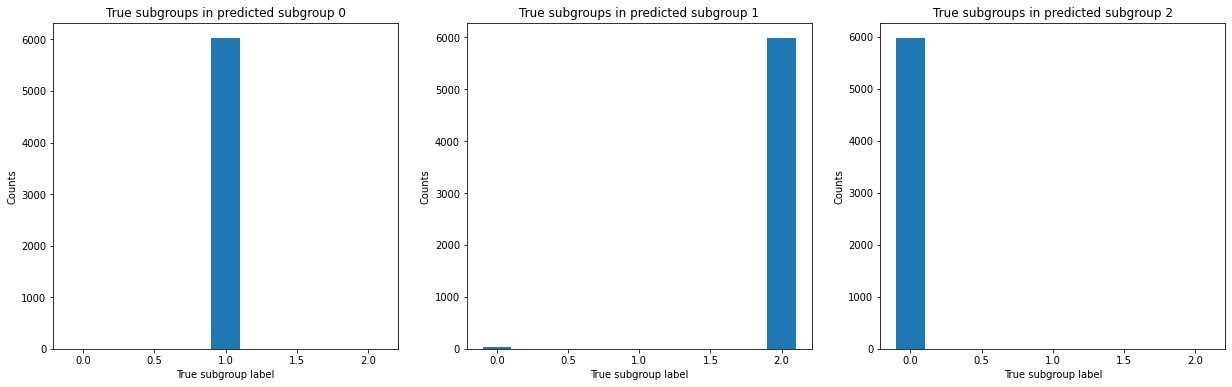

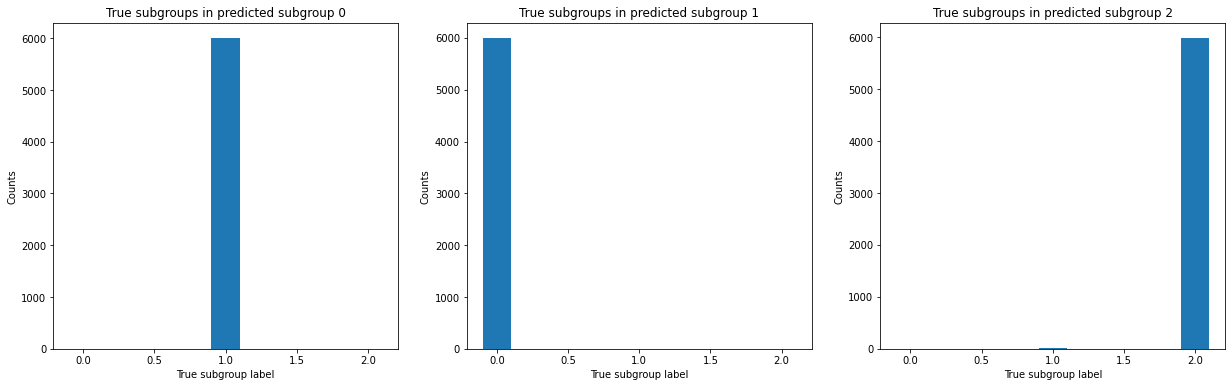

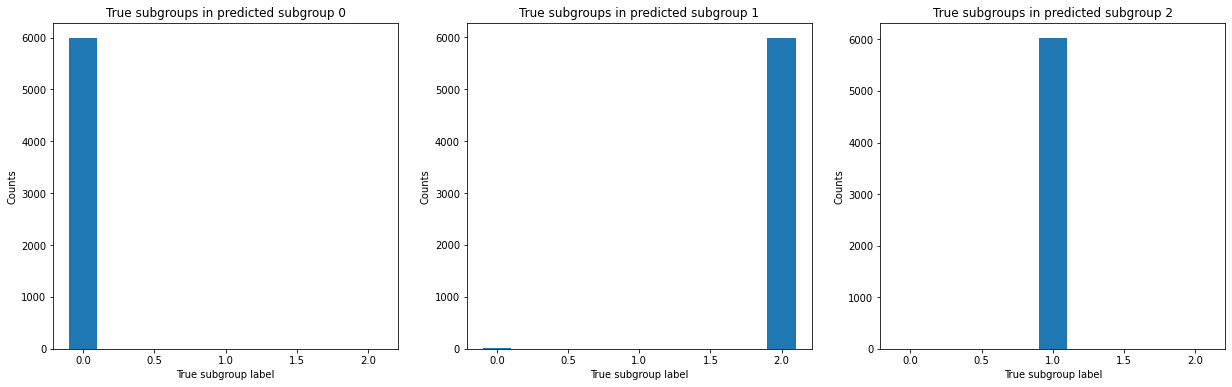

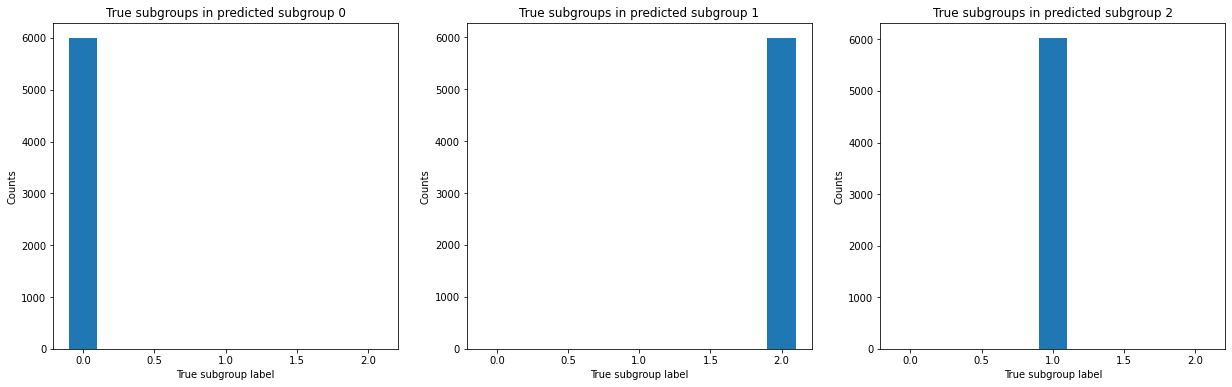

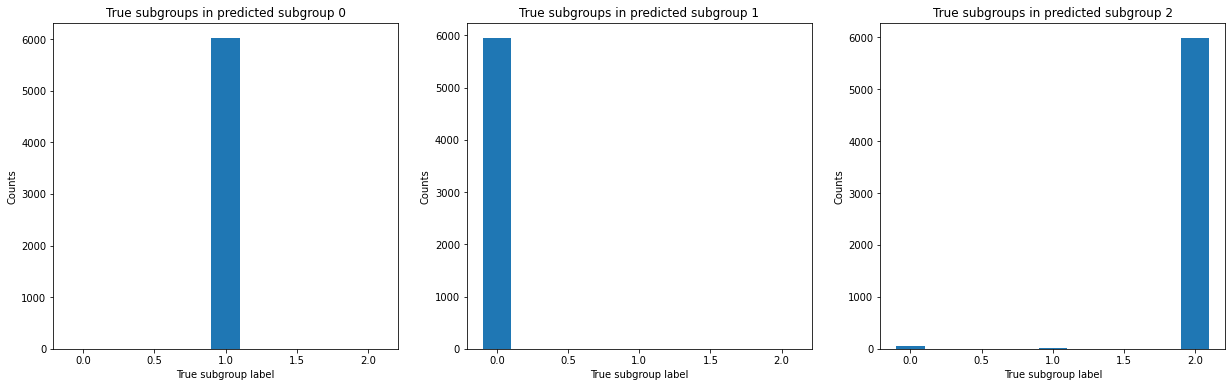

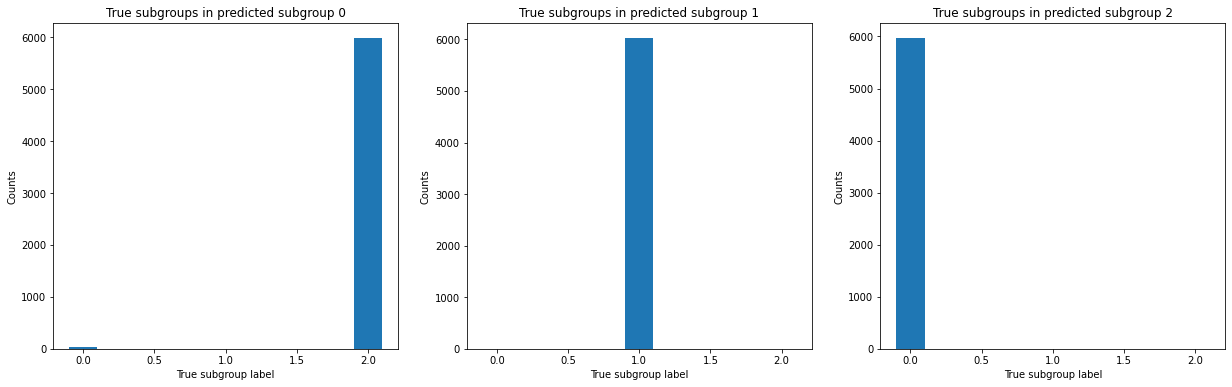

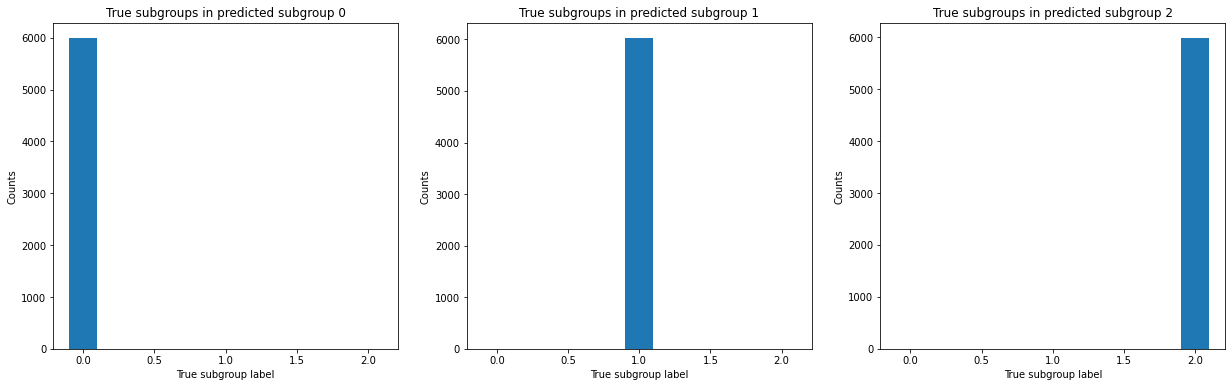

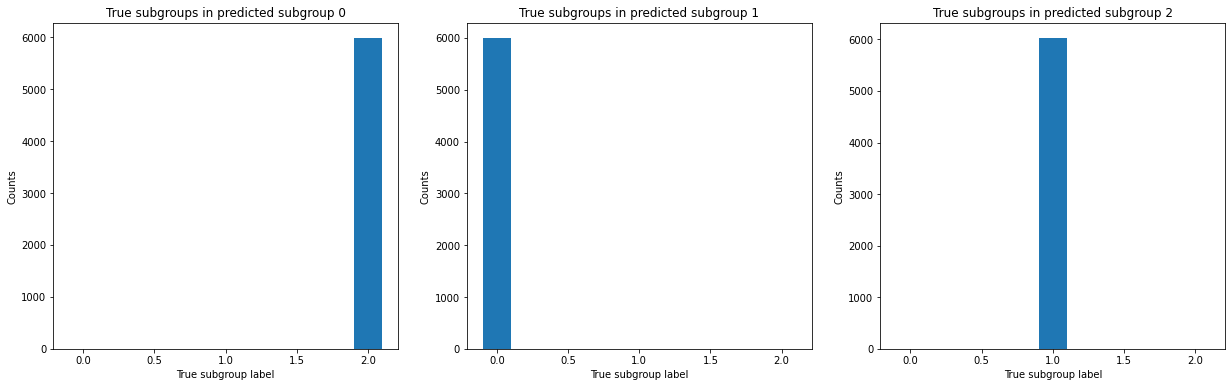

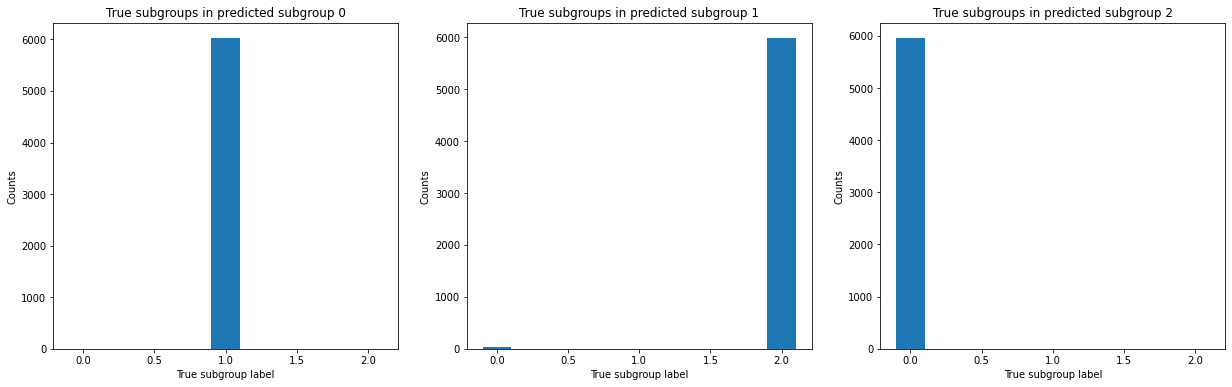

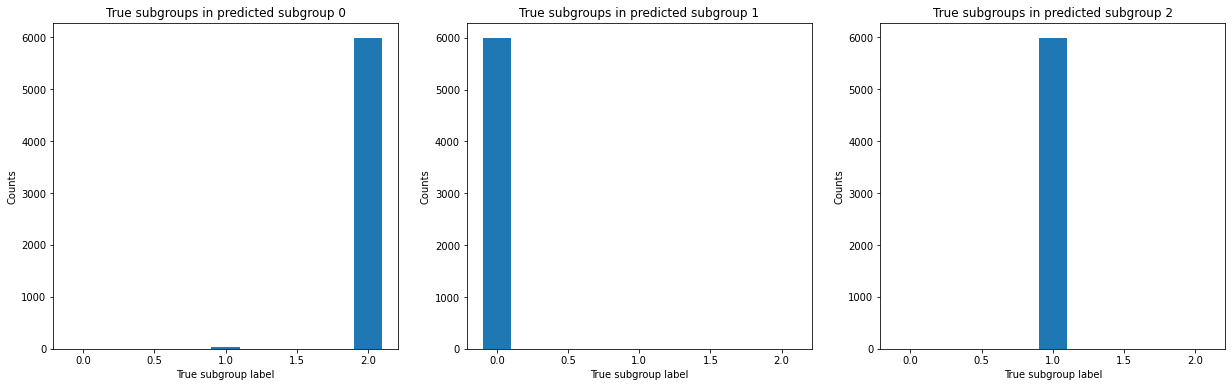

In [ ]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cfmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=True)

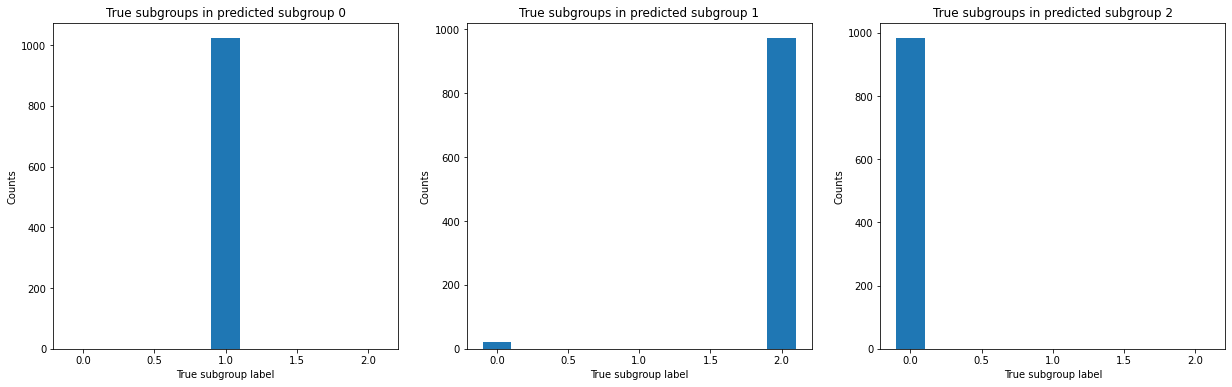

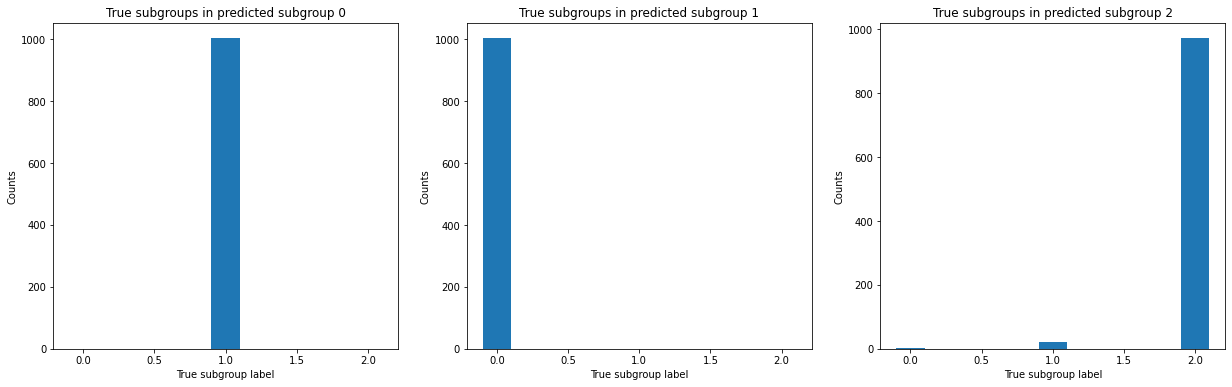

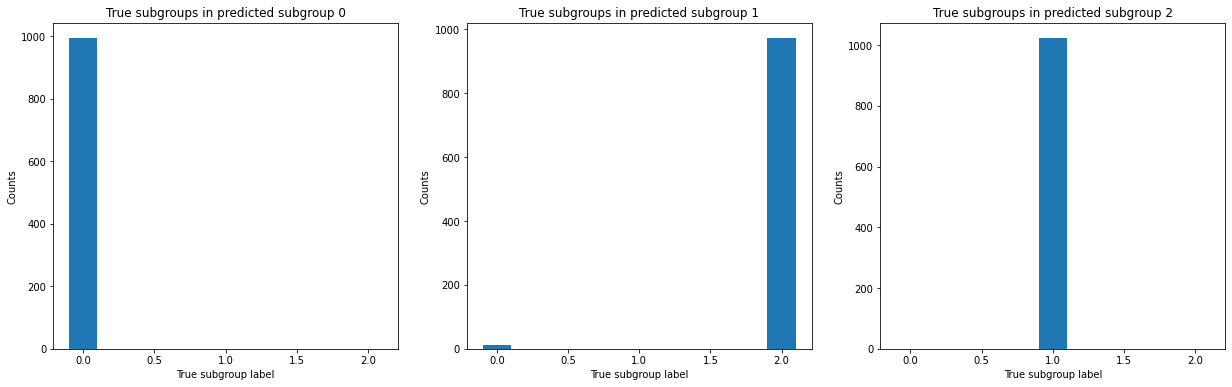

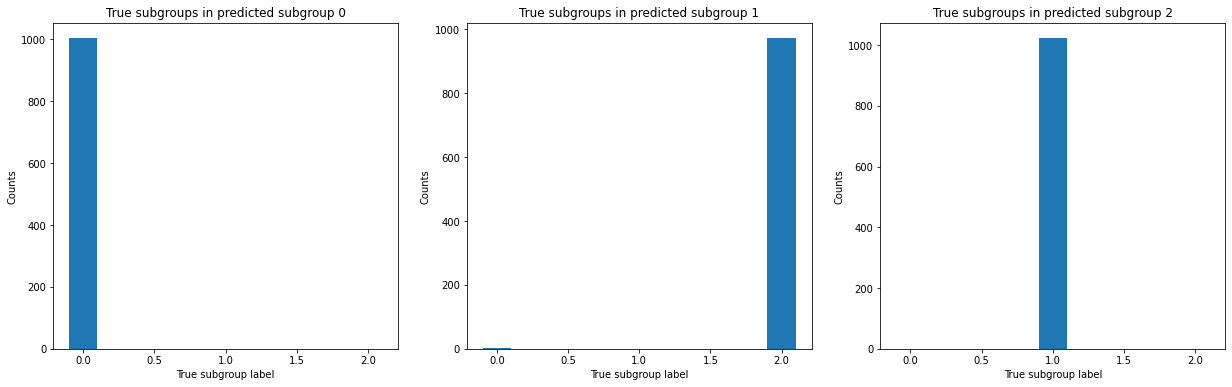

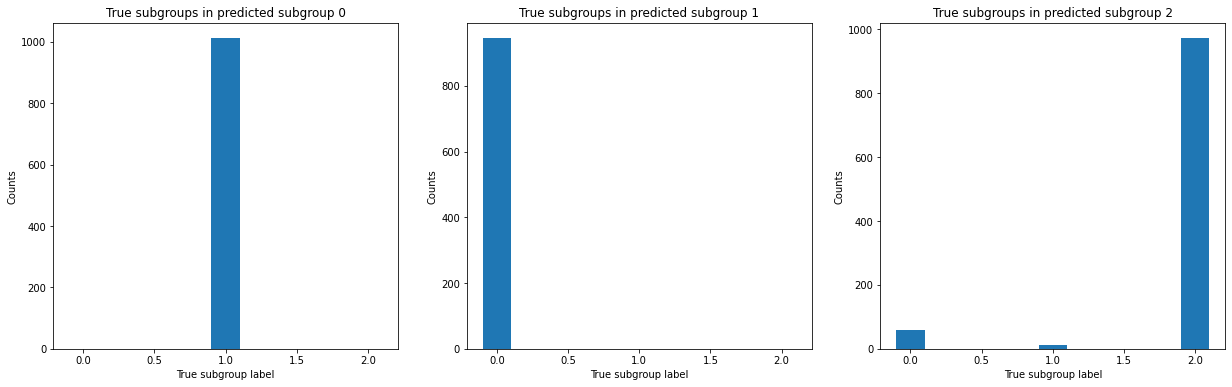

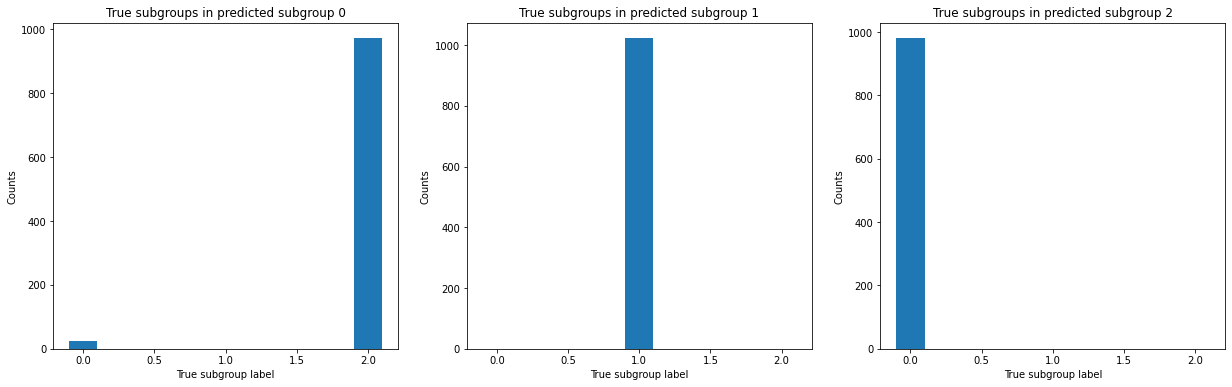

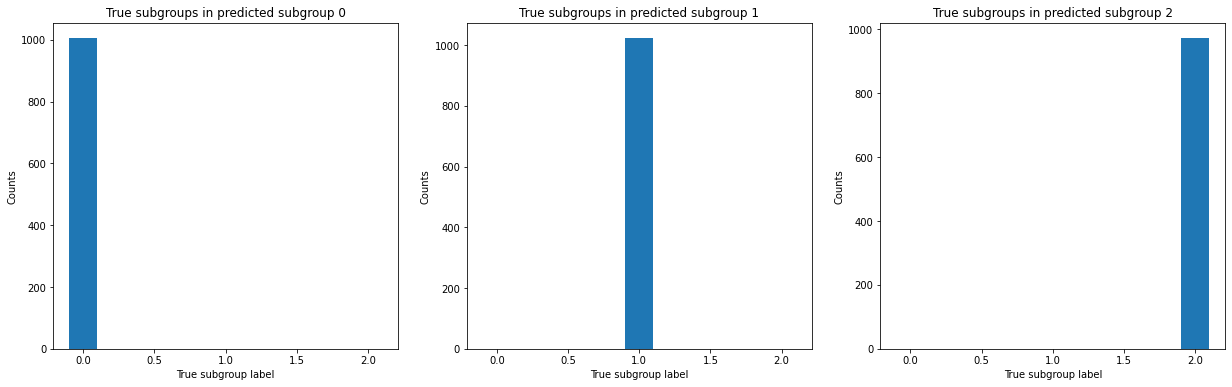

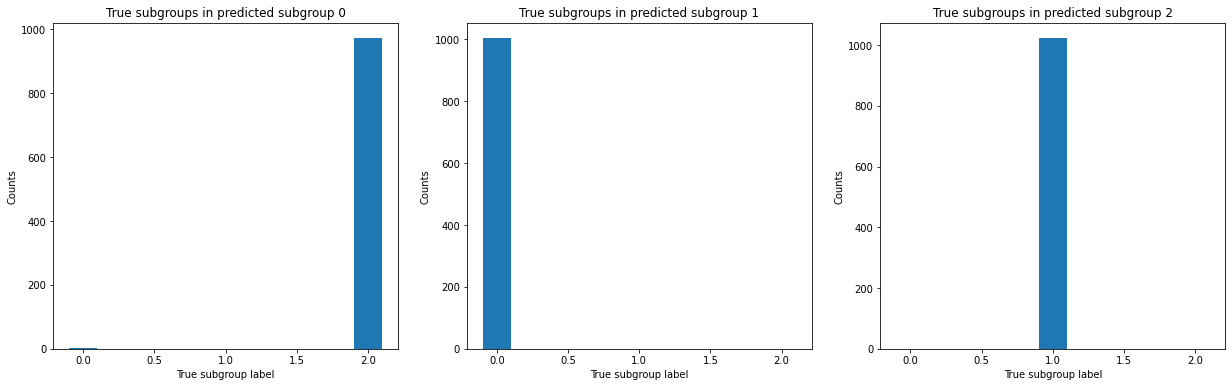

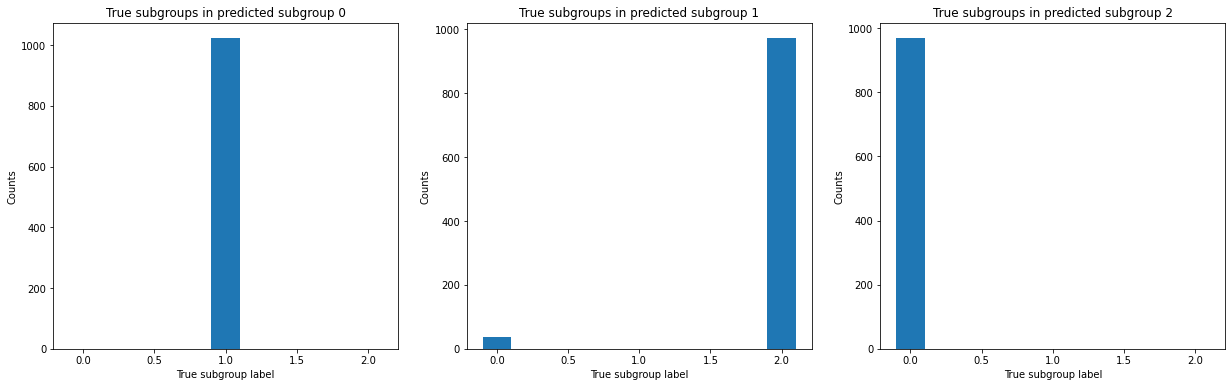

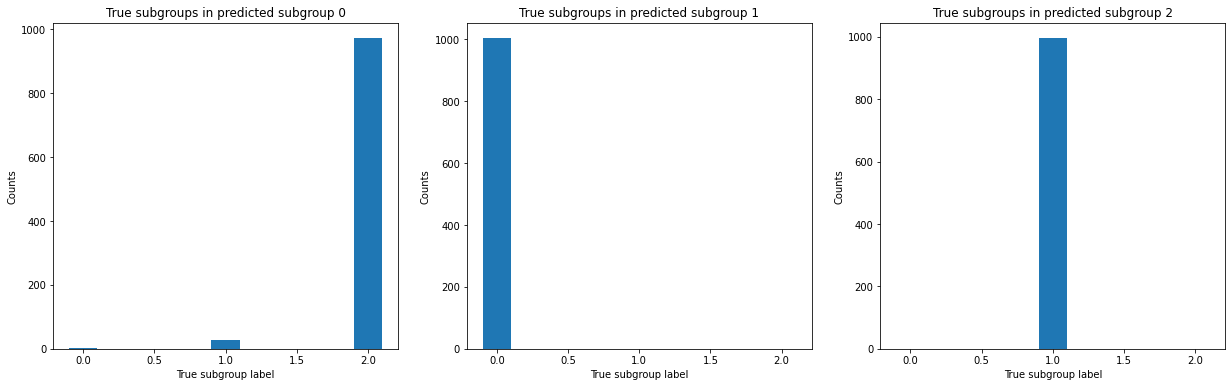

In [ ]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cfmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)

## Subgroup Label Prediction with MI regularizer

In [53]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [54]:
# 512 
# often 1/10 fails
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=3)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=3)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=30, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te, device=device, 
                                     num_classes=3, num_subgroups=3, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=DemographicParityGap(),
                                     lr=0.01, lr_adv=0.001, mi_weight=1.0, anomaly_detection=False)

--------Run 0--------
Train homogeneity score: 0.997 ; Train completeness score: 0.997
Test homogeneity score: 0.994 ; Test completeness score: 0.994
Adversary train accuracy (target=biased predictions): 0.60511
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99183
--------Run 2--------
Train homogeneity score: 0.999 ; Train completeness score: 0.999
Test homogeneity score: 0.998 ; Test completeness score: 0.998
Adversary train accuracy (target=biased predictions): 0.99206
--------Run 3--------
Train homogeneity score: 0.999 ; Train completeness score: 0.999
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.98989
--------Run 4--------
Train homogeneity score: 0.004 ; Train completeness score: 0.167
Test homogeneity score: 0.003 ; Test completeness score: 0.161
Ad

In [55]:
with open('../results/cfmnist_3_3_dpg.pkl', 'wb') as f:
  pkl.dump(results, f)

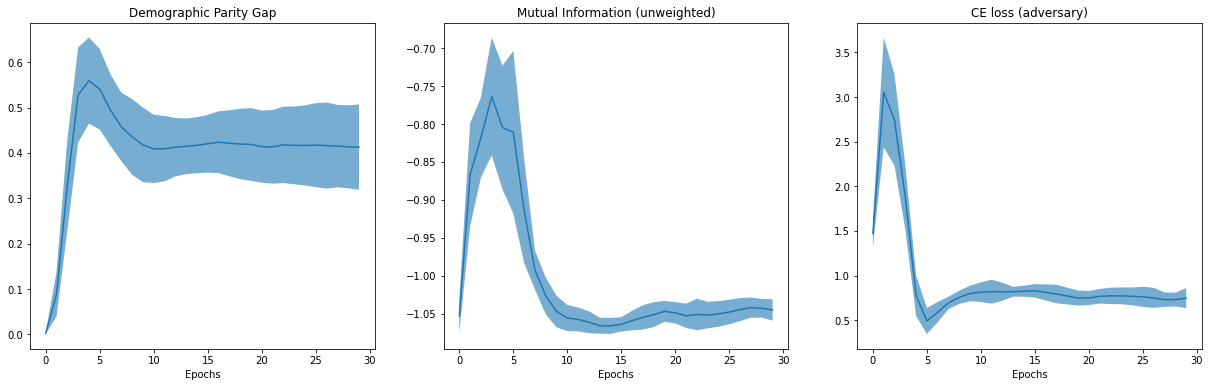

In [58]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'])

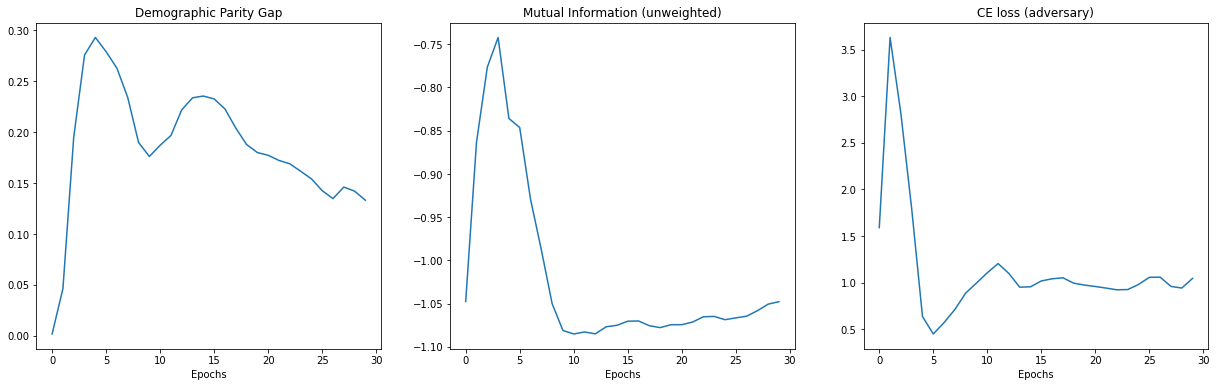

In [61]:
failed_runs = [4]
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=failed_runs)

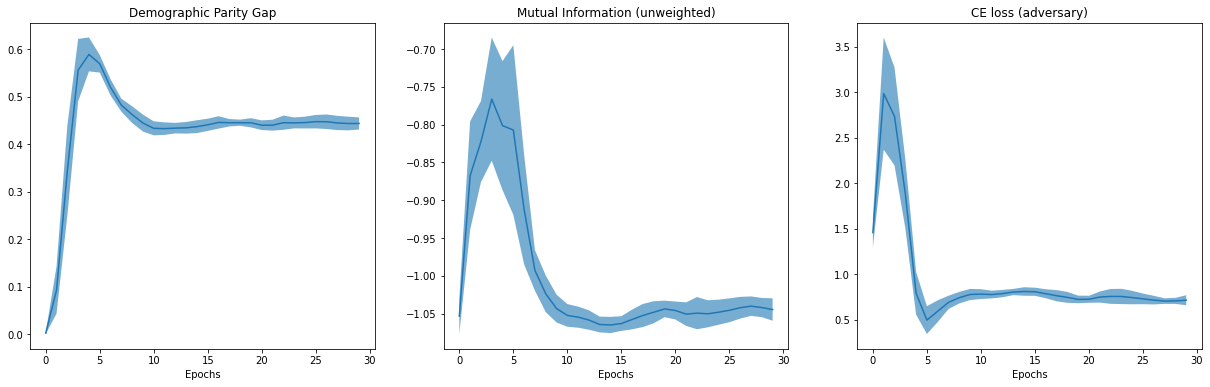

In [63]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[i for i in range(10) if i not in failed_runs])

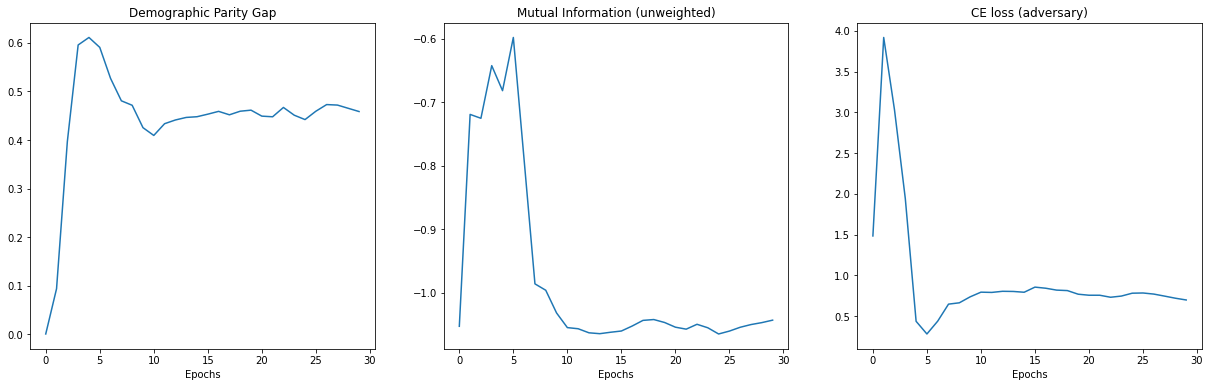

In [64]:
perfect_run = [1]
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=perfect_run)

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.916388
      2                 1.000000
1     0                 0.851735
      1                 0.993118
      2                 1.000000
2     0                 0.936102
      1                 0.965870
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.965870
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.923077
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.969283
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997419
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.969283
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.965870
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994420
      2                 1.000000
2     0                 0.936102
      1                 0.969283
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997604
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.969283
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997419
      1                 0.919732
      2                 1.000000
1     0                 0.851735
      1                 0.994234
      2                 1.000000
2     0                 0.936102
      1                 0.965870
      2                 1.000000

acc_biased_preds
label subgroup                  
0     0                 0.997235
      1                 0.923077
      2                 1.000000
1     0                 0.851735
      1                 0.993862
      2                 1.000000
2     0                 0.936102
      1                 0.965870
      2                 1.000000

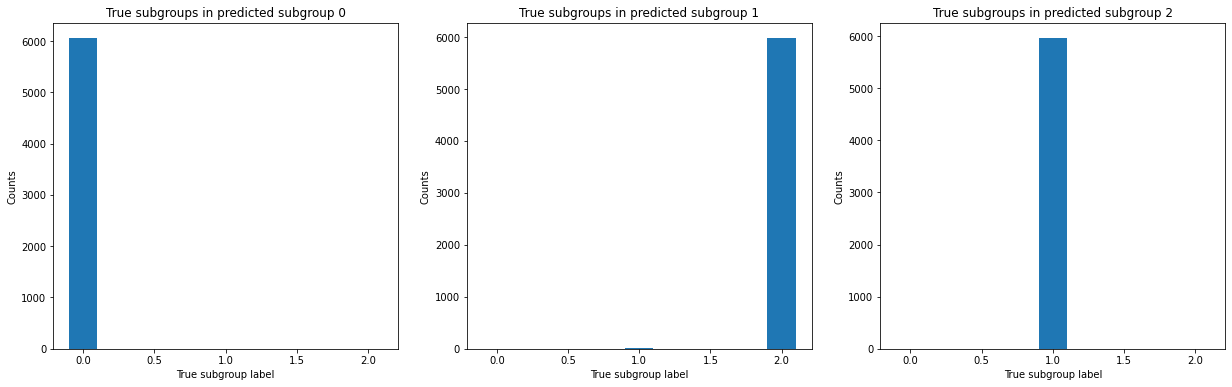

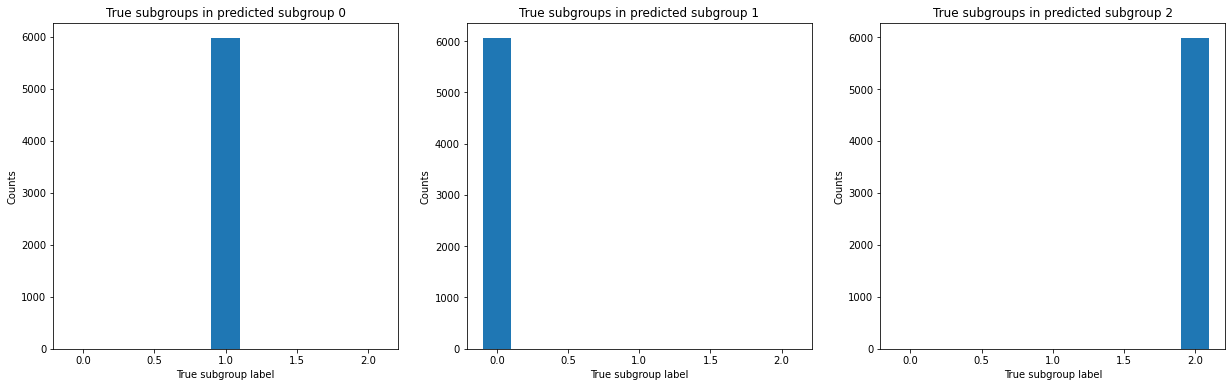

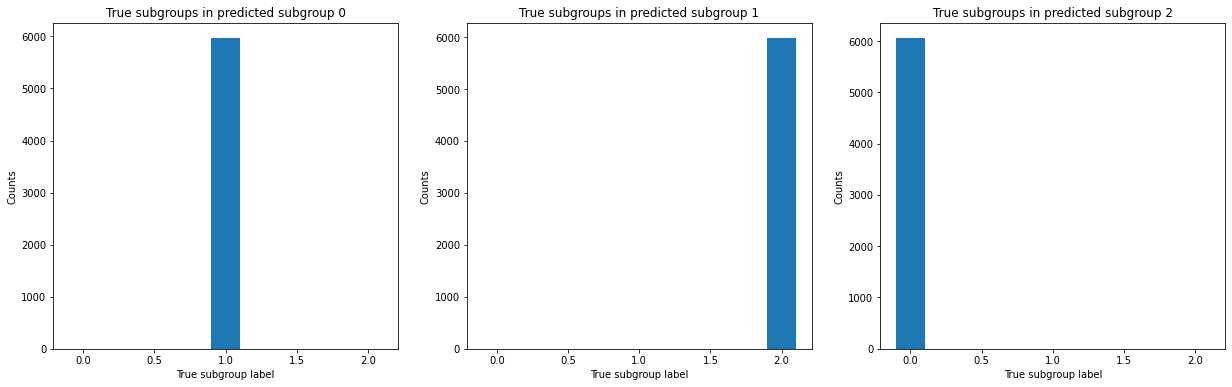

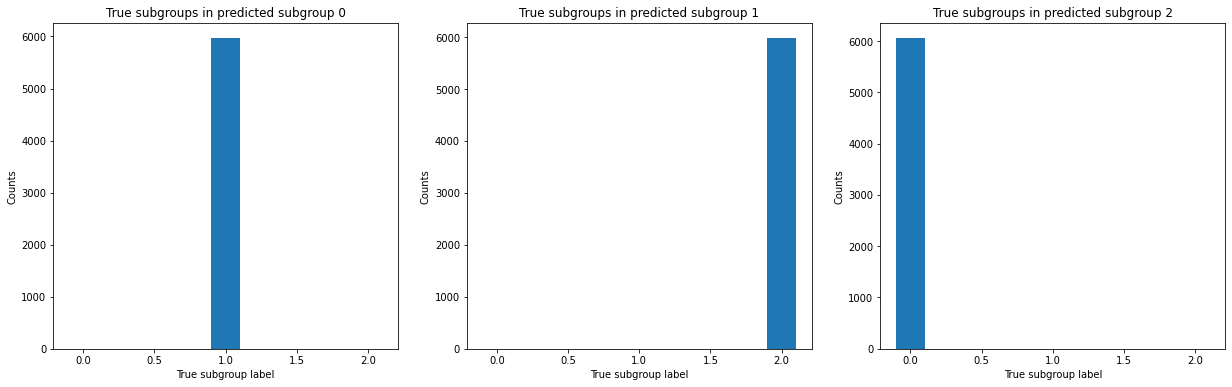

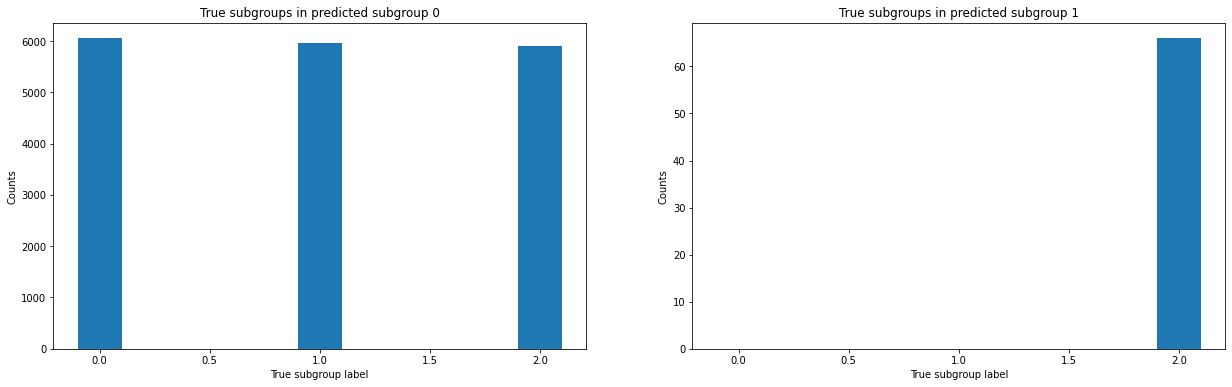

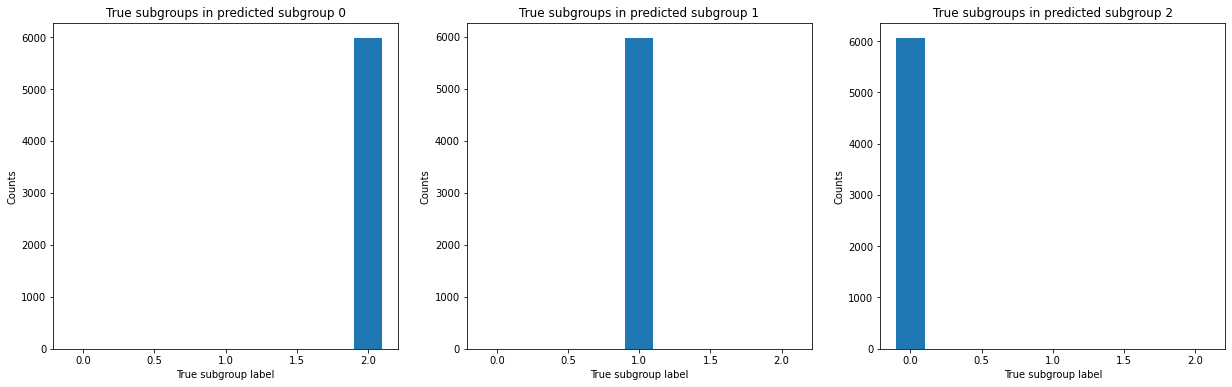

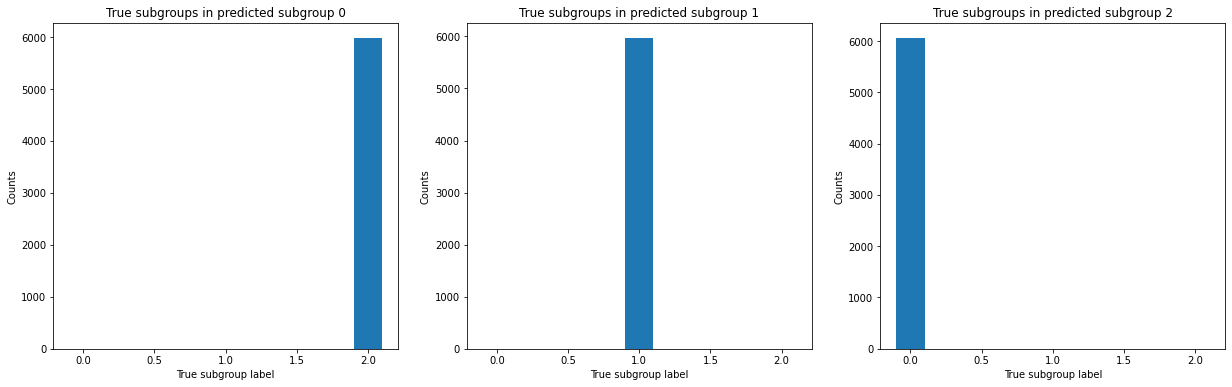

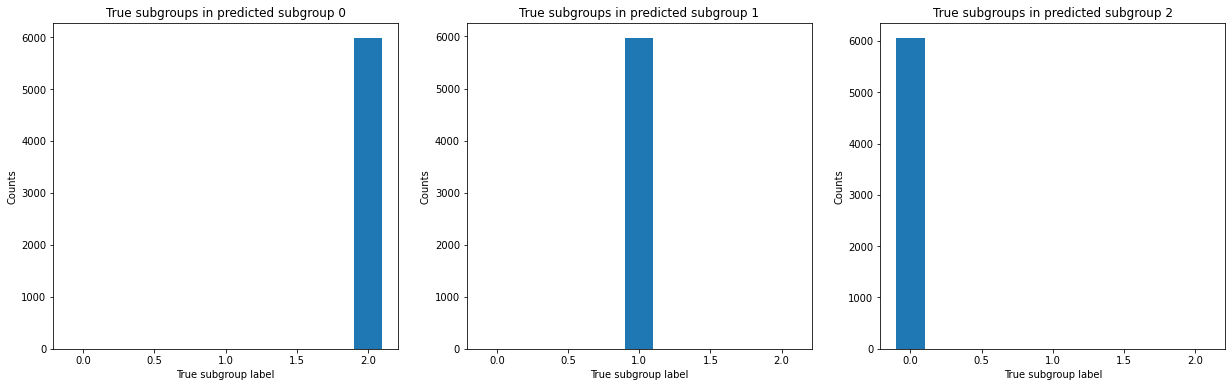

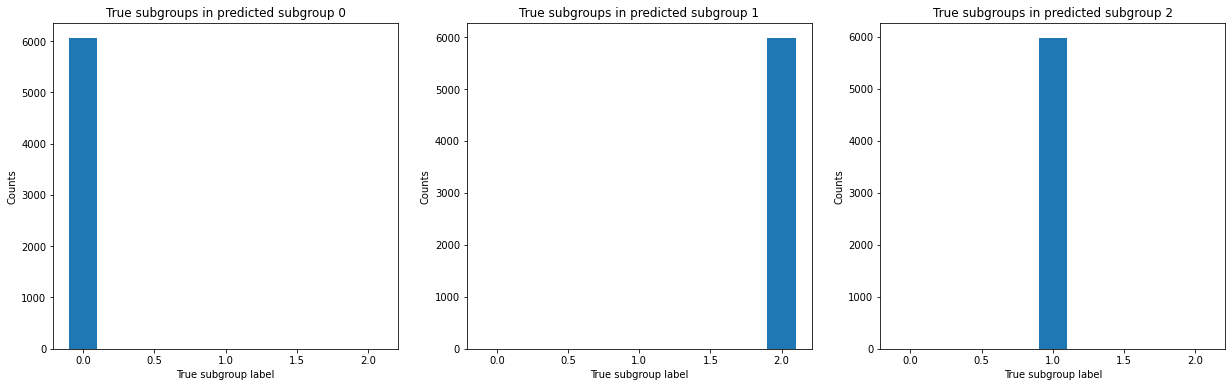

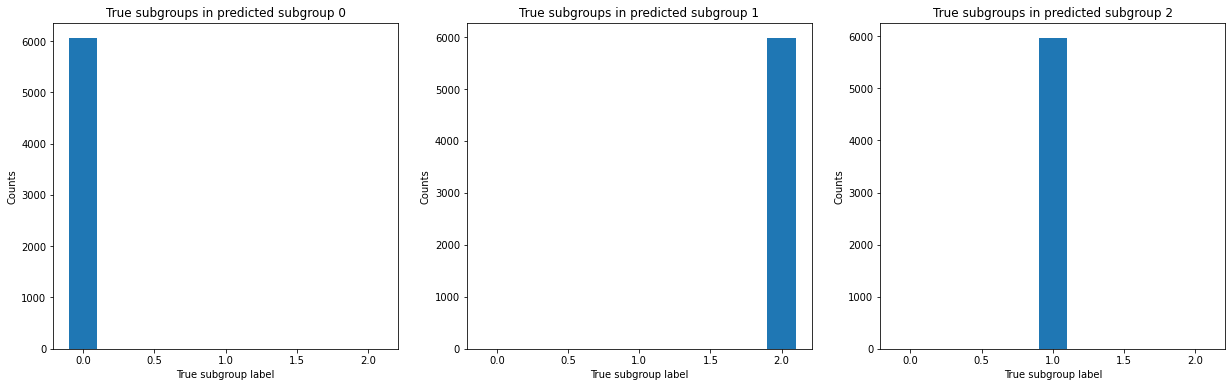

In [65]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cfmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=True)

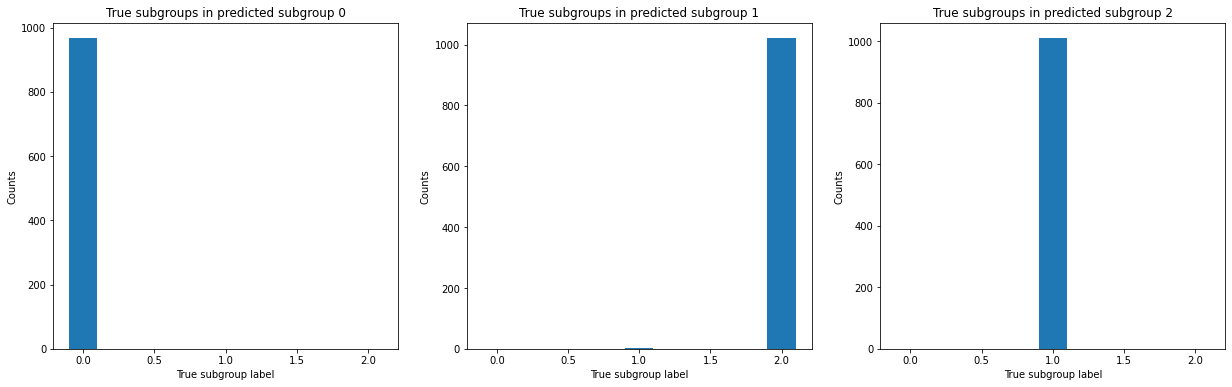

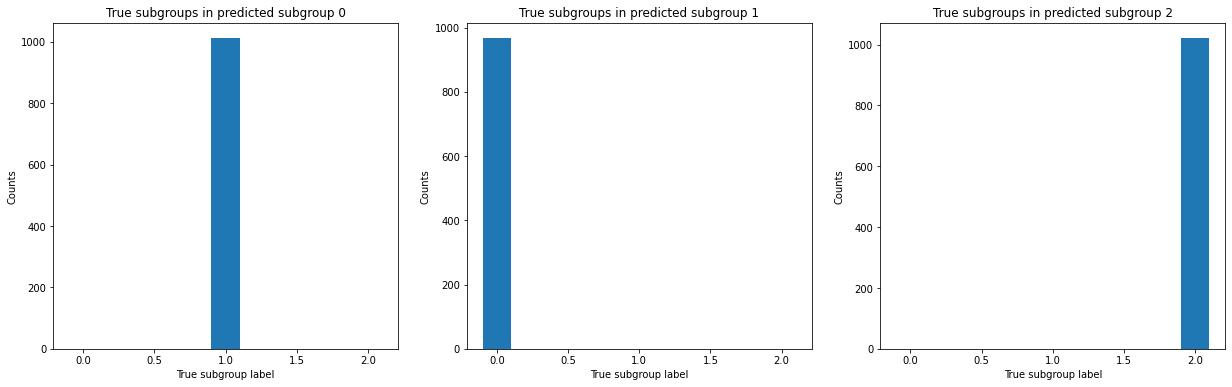

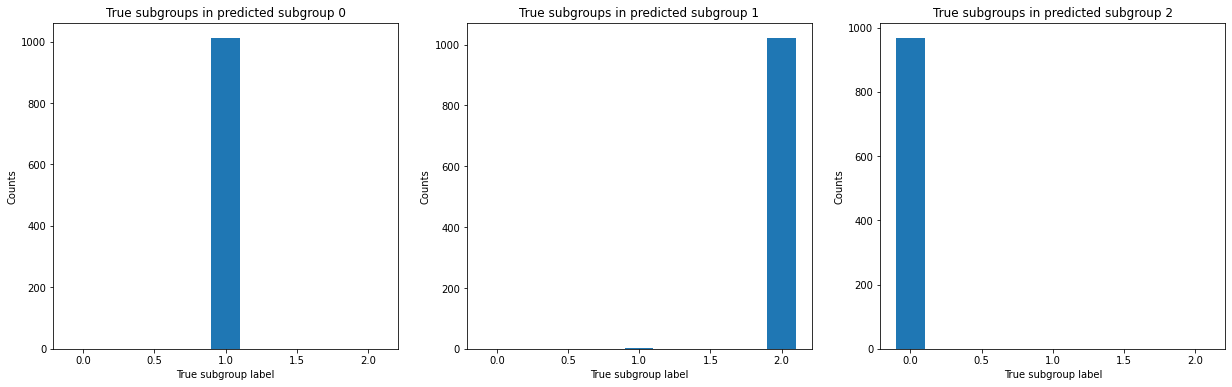

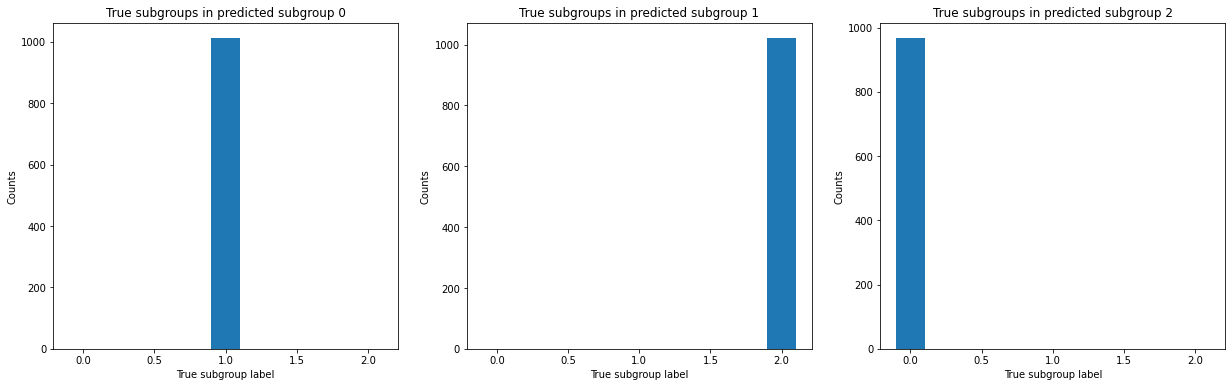

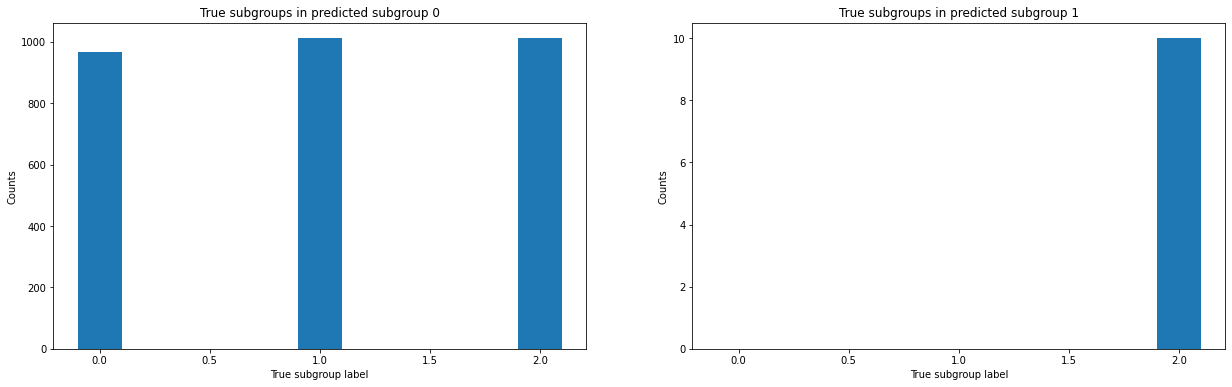

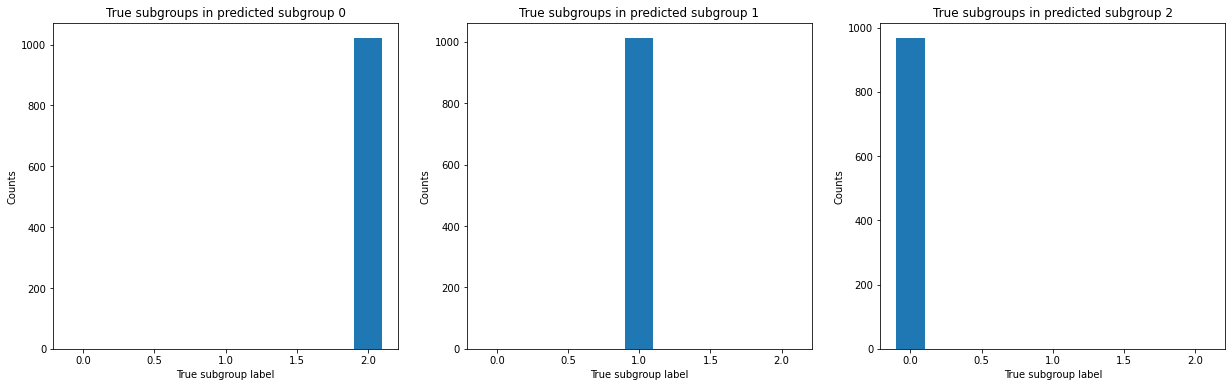

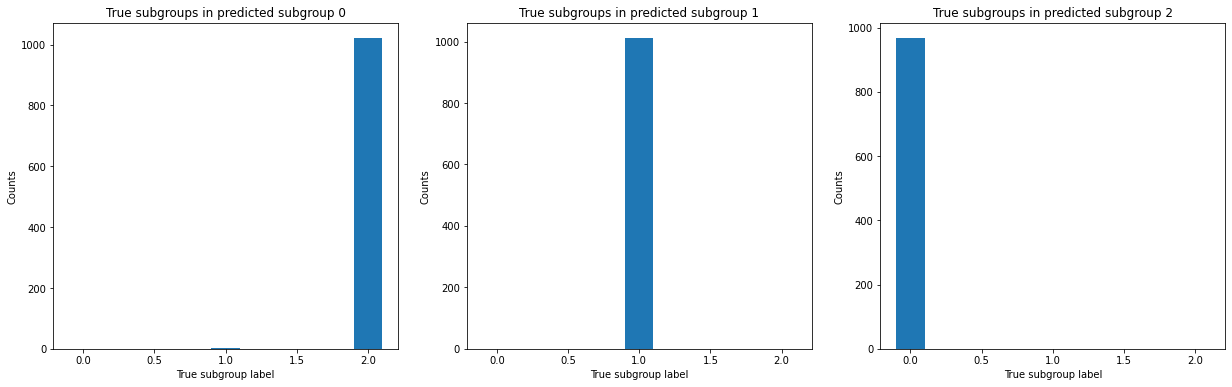

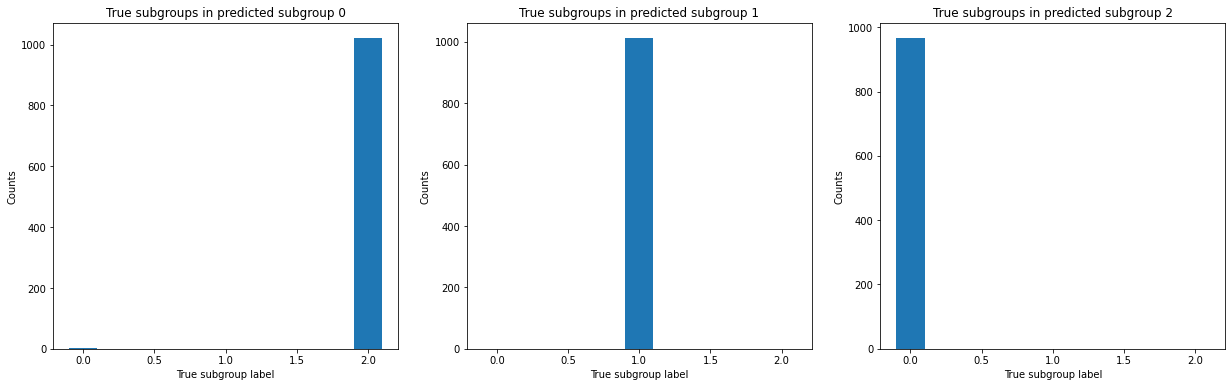

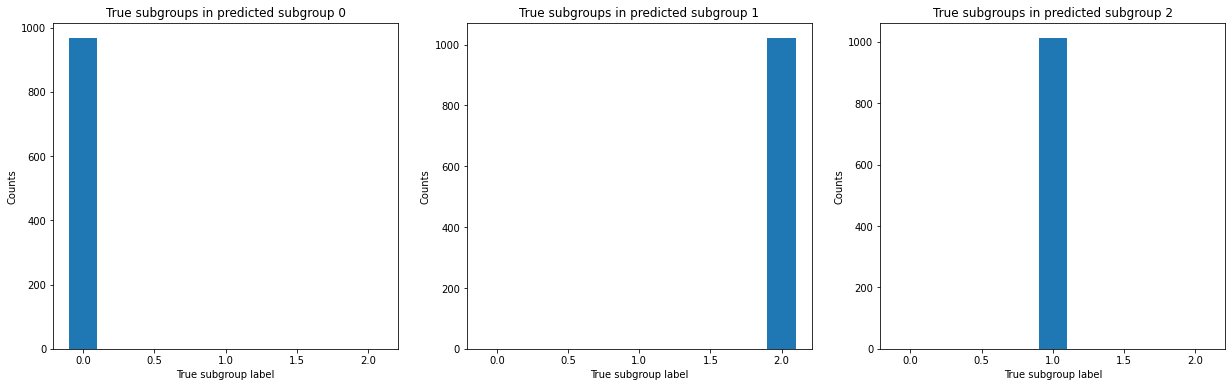

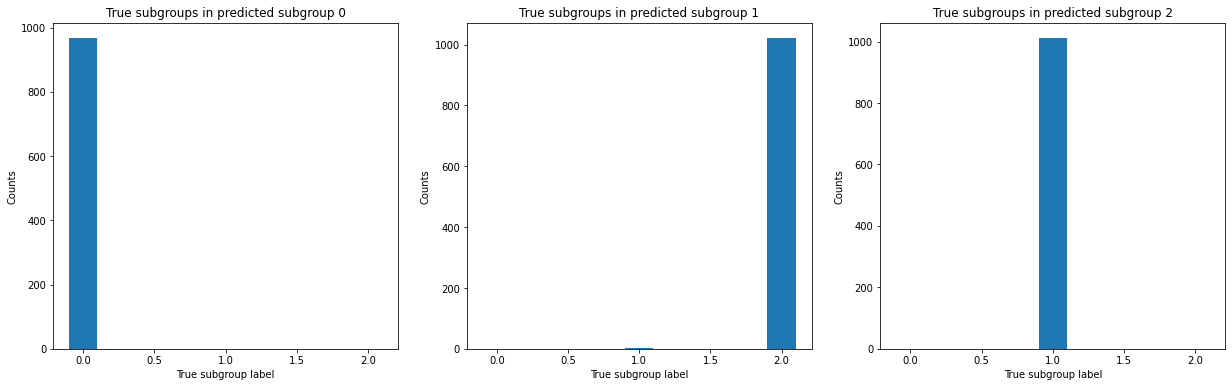

In [66]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cfmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)

# Reduced CFashionMNIST: 10 classes (clothes), 2 subgroups (colors)

In [109]:
BATCH_SIZE = 4096 
cfmnist_tr = CustomDatasetCFMNIST(train=True, main_color_prop=0.95, class_colors=[0]*5 + [1]*5, classes=list(range(10)))
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 
cfmnist_te = CustomDatasetCFMNIST(train=False, main_color_prop=0.1, class_colors=[0]*5 + [1]*5, classes=list(range(10)), means=cfmnist_tr.means, stds=cfmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cfmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=512, output_dim=10).to(device)
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.05)
n_epochs = 3

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=1.96713
Epoch 2: loss=0.96504


Train set
Average accuracy: 0.76078


accuracy
label subgroup          
0     0         0.710742
      1         0.000000
1     0         0.921869
      1         0.421212
2     0         0.647152
      1         0.000000
3     0         0.801586
      1         0.049231
4     0         0.633521
      1         0.000000
5     0         0.884244
      1         0.623484
6     0         0.000000
      1         0.897247
7     0         0.494737
      1         0.858618
8     0         0.000000
      1         0.871329
9     0         0.491409
      1         0.916973

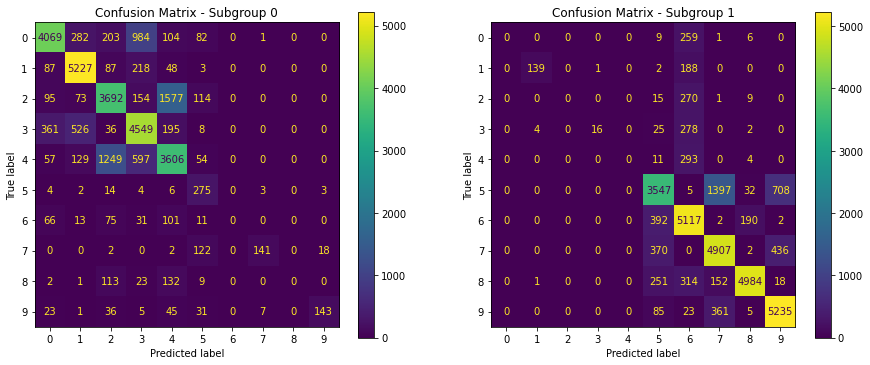

In [113]:
print('Train set')
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Test set
Average accuracy: 0.28080


accuracy
label subgroup          
0     0         0.635417
      1         0.000000
1     0         0.954023
      1         0.408543
2     0         0.623762
      1         0.000000
3     0         0.776596
      1         0.037528
4     0         0.596491
      1         0.000000
5     0         0.883539
      1         0.560748
6     0         0.000000
      1         0.863636
7     0         0.488398
      1         0.884211
8     0         0.000000
      1         0.886076
9     0         0.490088
      1         0.945652

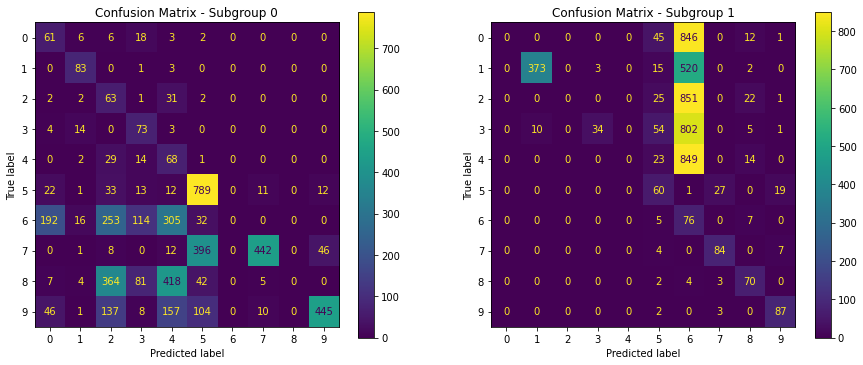

In [114]:
print('Test set')
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

In [80]:
device_cpu = torch.device('cpu')
torch.save(ref_clf.to(device_cpu), '../results/ref_clf_cfmnist_all_2colors.pkl')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ref_clf = torch.load('../results/ref_clf_cfmnist_all_2colors.pkl').to(device)

In [115]:
# get biased preds -
for i in range(cfmnist_tr.__len__()):
   _, img, _, _, _ = cfmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cfmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [116]:
# check demographic parity gap for true subgroups (whole train set)
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cfmnist_tr.subgroup).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.0253],
        [0.0417],
        [0.0339],
        [0.0479],
        [0.0378],
        [0.0176],
        [0.0503],
        [0.0492],
        [0.0303],
        [0.0430]])


tensor(0.0377)

In [117]:
# check eq odds gap for true subgroups
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cfmnist_tr.subgroup).float()
biased_preds = cfmnist_tr.biased_predictions.long()

-EqualizedOddsGap(print_gaps=True)(out, biased_preds, cfmnist_tr.label, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.5052],
        [0.2507],
        [0.4188],
        [0.5660],
        [0.4013],
        [0.0680],
        [0.8051],
        [0.1324],
        [0.7592],
        [0.1811]])


tensor(0.4088)

In [118]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cfmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [127]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=128, output_dim=2)
adv = MLP(n_layers=1, input_dim=128, hidden_dim=128, output_dim=10)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=5, dataset_tr=cfmnist_tr, dataset_te=cfmnist_te, device=device, 
                                     num_classes=10, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=EqualizedOddsGap(),
                                     lr=0.01, lr_adv=0.001, mi_weight=1.0, anomaly_detection=False)

--------Run 0--------
Train homogeneity score: 0.640 ; Train completeness score: 0.655
Test homogeneity score: 0.891 ; Test completeness score: 0.892
Adversary train accuracy (target=biased predictions): 0.07830
--------Run 1--------
Train homogeneity score: 0.482 ; Train completeness score: 0.519
Test homogeneity score: 0.834 ; Test completeness score: 0.837
Adversary train accuracy (target=biased predictions): 0.16895
--------Run 2--------
Train homogeneity score: 0.781 ; Train completeness score: 0.785
Test homogeneity score: 0.929 ; Test completeness score: 0.929
Adversary train accuracy (target=biased predictions): 0.21090
--------Run 3--------
Train homogeneity score: 0.748 ; Train completeness score: 0.754
Test homogeneity score: 0.908 ; Test completeness score: 0.908
Adversary train accuracy (target=biased predictions): 0.16212
--------Run 4--------
Train homogeneity score: 0.706 ; Train completeness score: 0.715
Test homogeneity score: 0.894 ; Test completeness score: 0.895
Ad

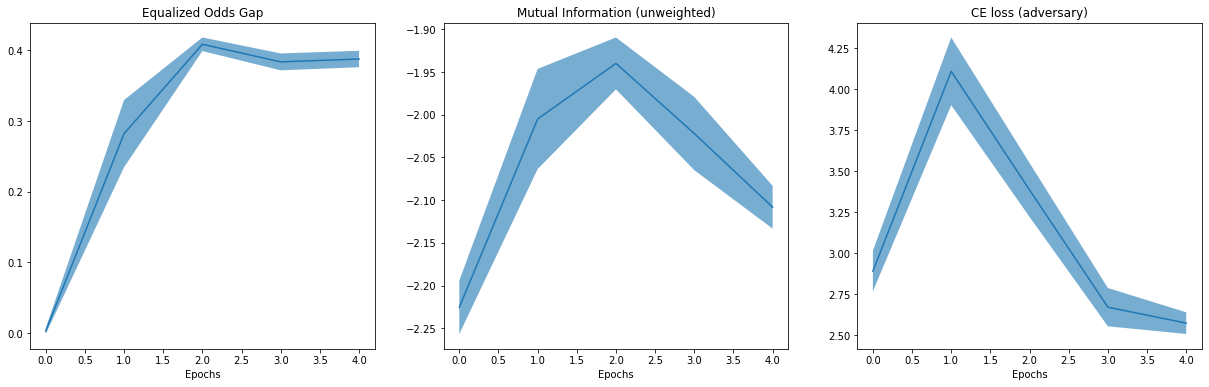

In [128]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], loss_name='Equalized Odds Gap')

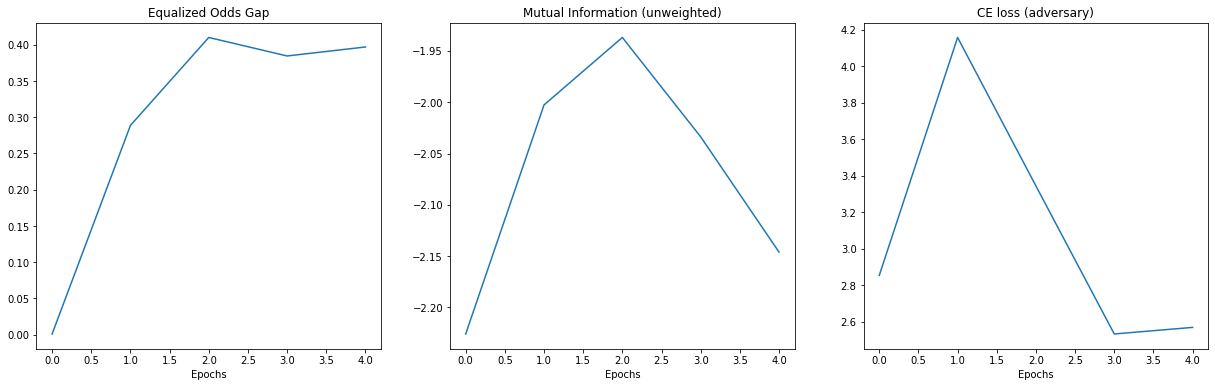

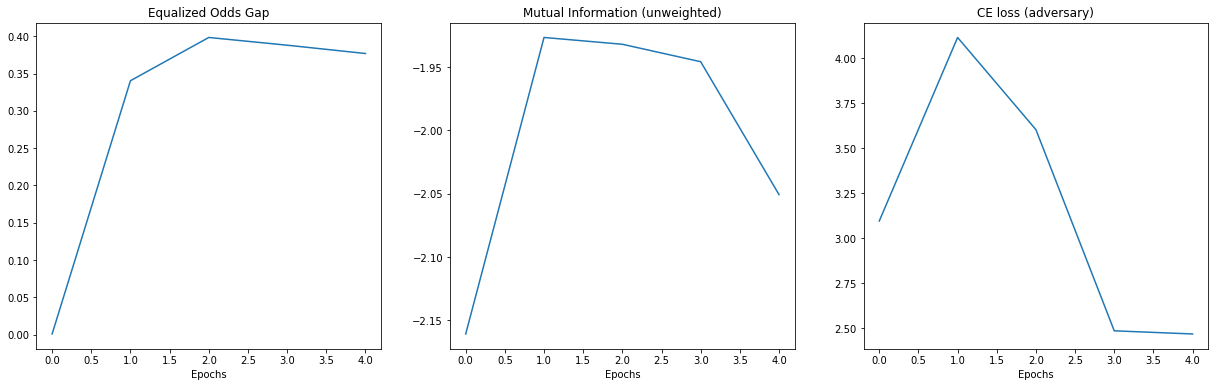

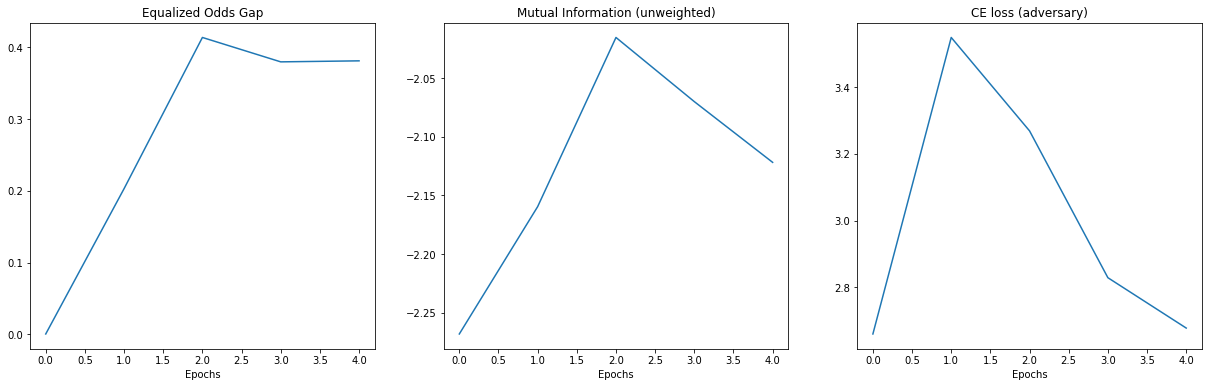

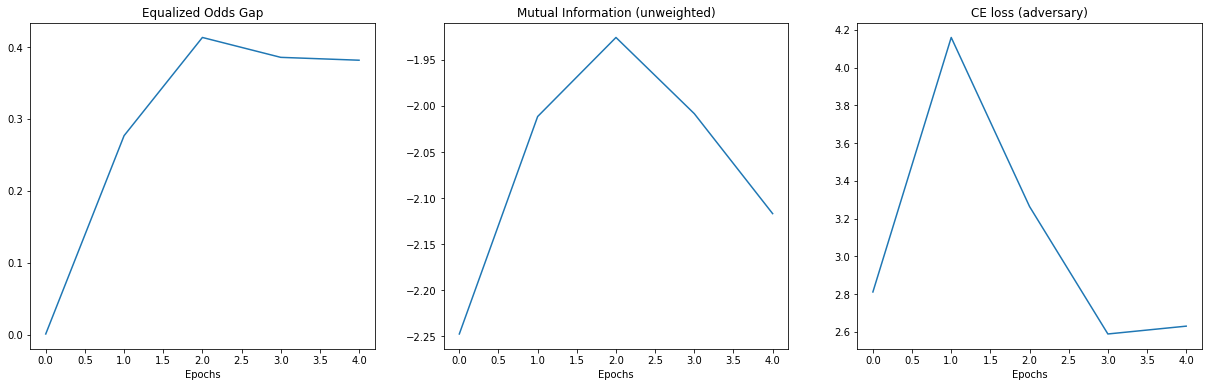

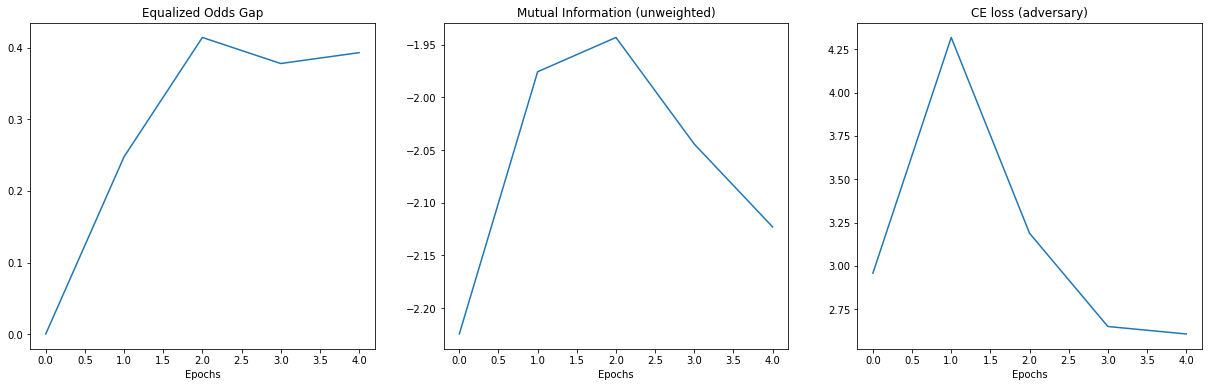

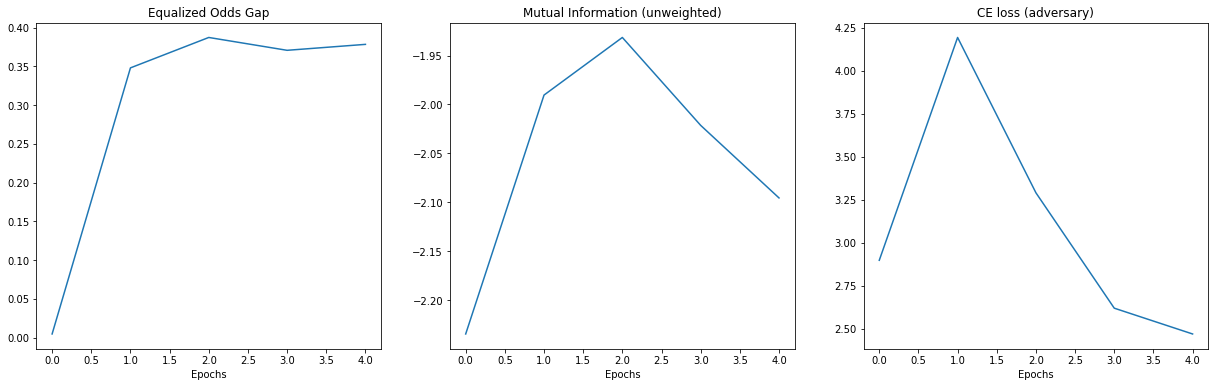

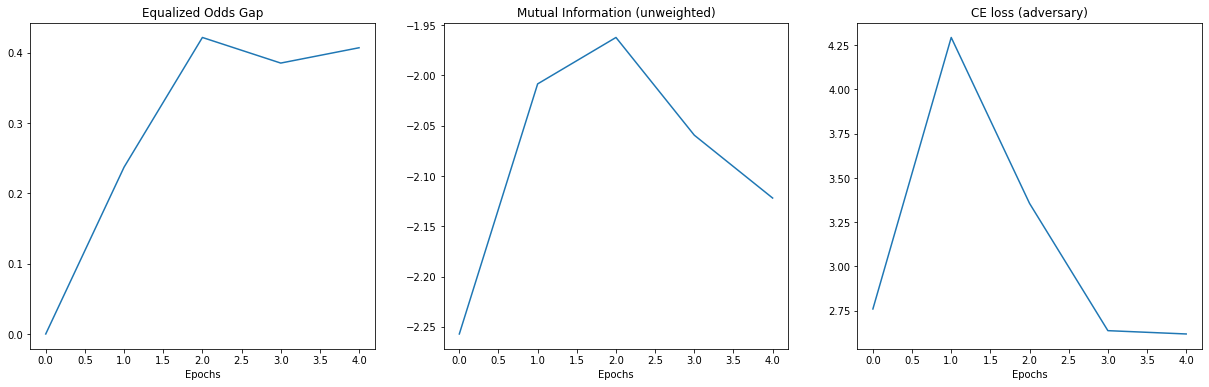

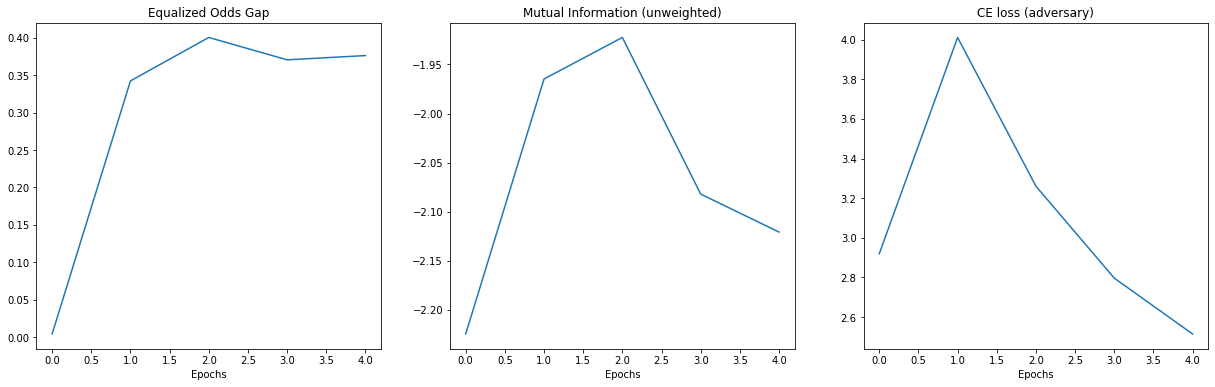

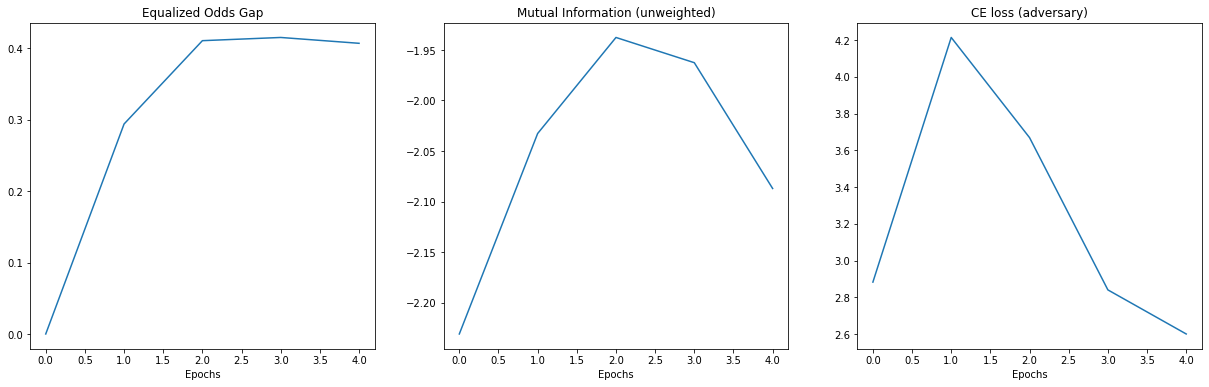

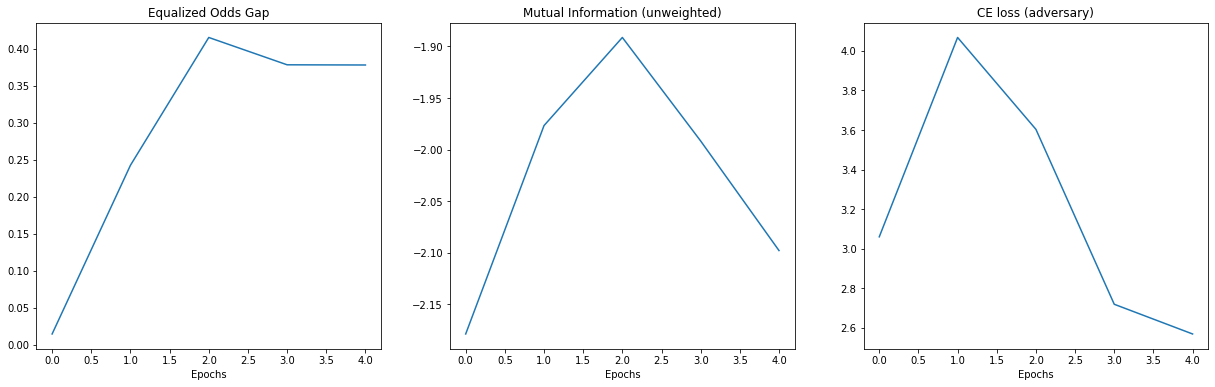

In [129]:
for i in range(10):
  plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], loss_name='Equalized Odds Gap', runs=[i])

In [130]:
with open('../results/cfmnist_10_2_eog.pkl', 'wb') as f:
  pkl.dump(results, f)

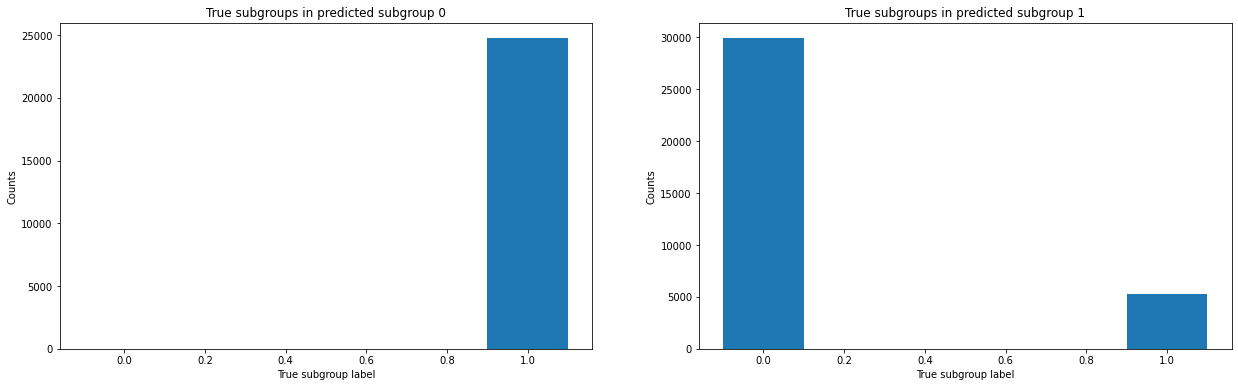

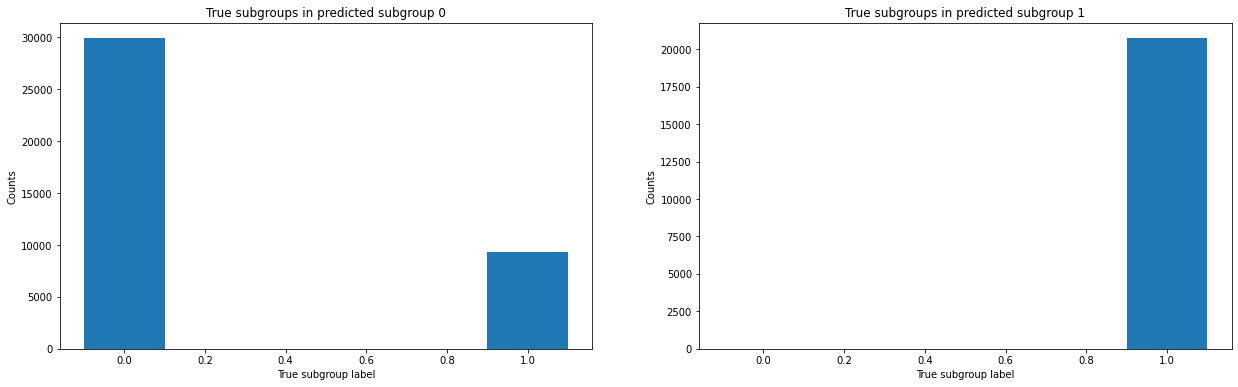

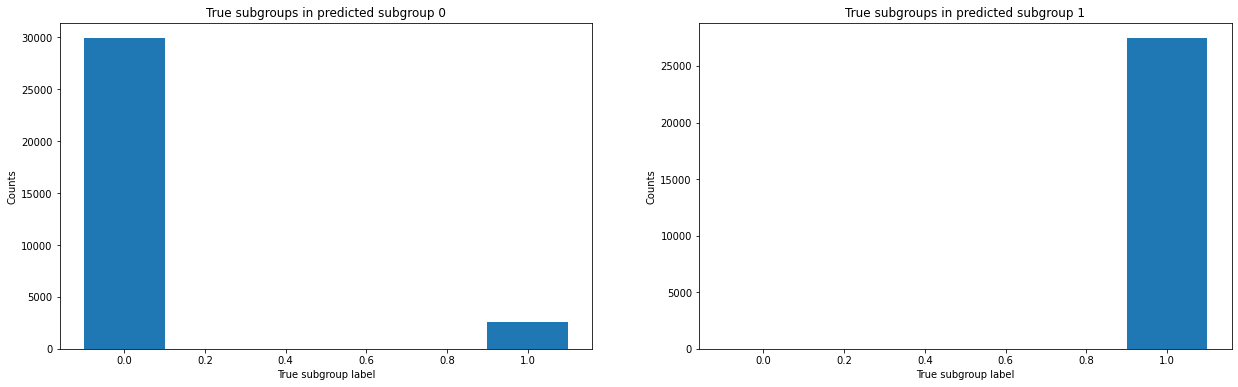

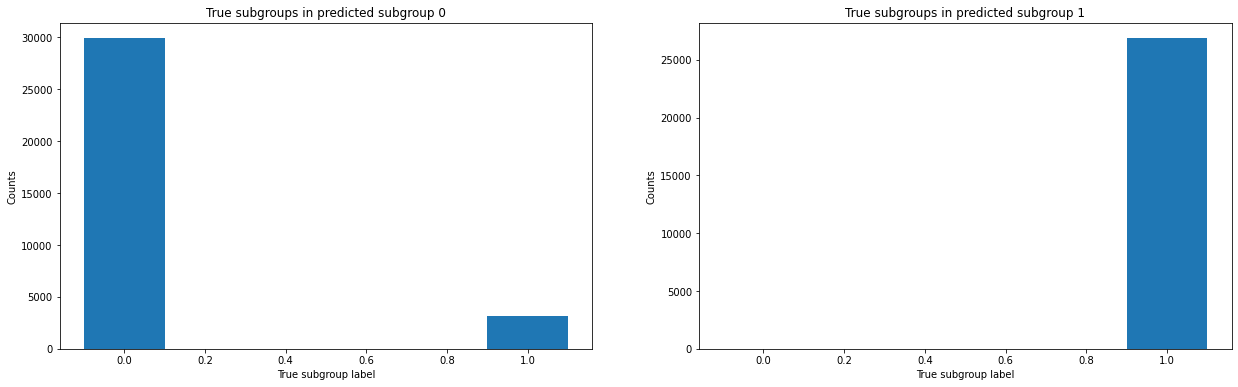

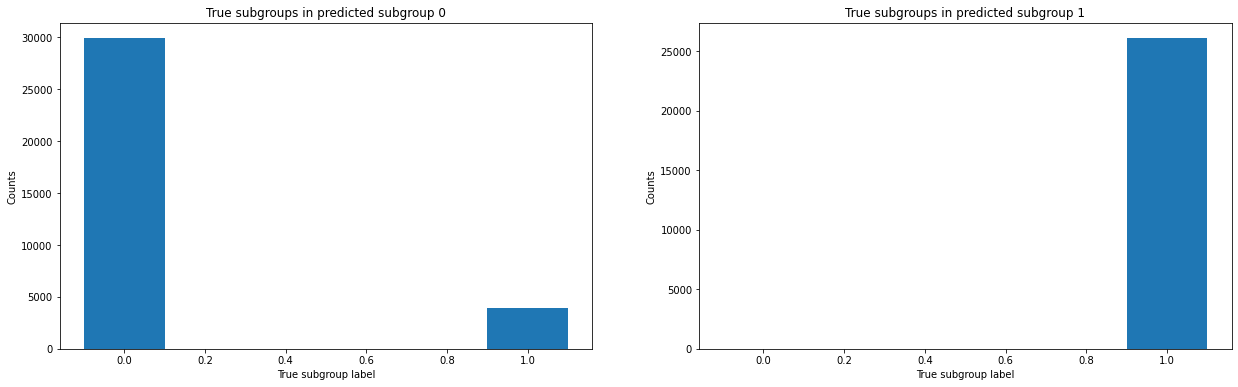

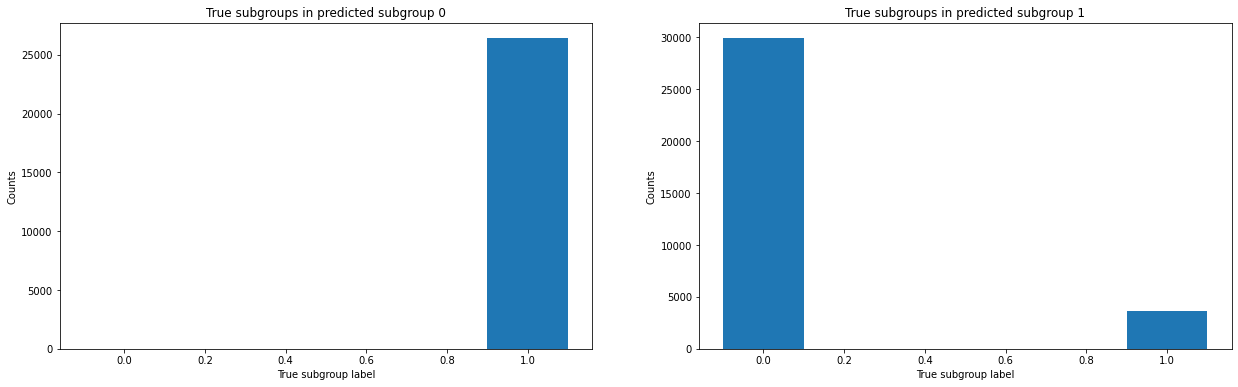

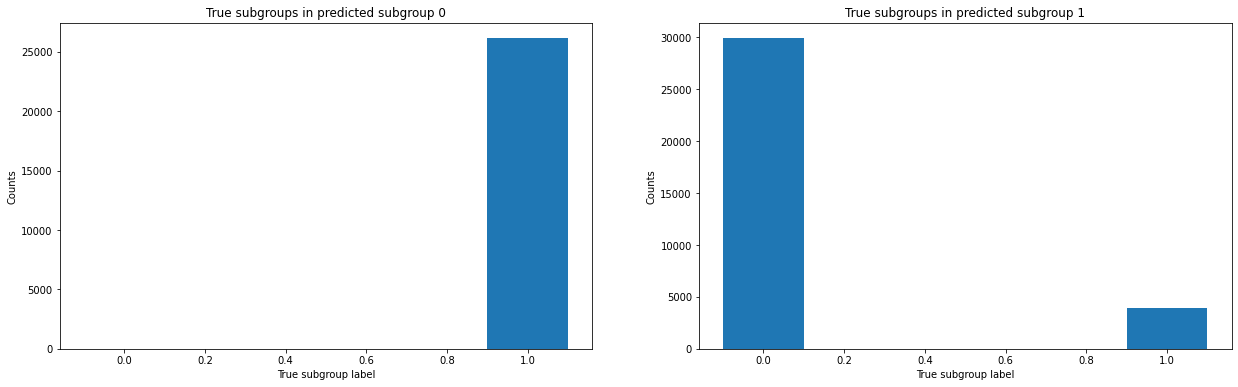

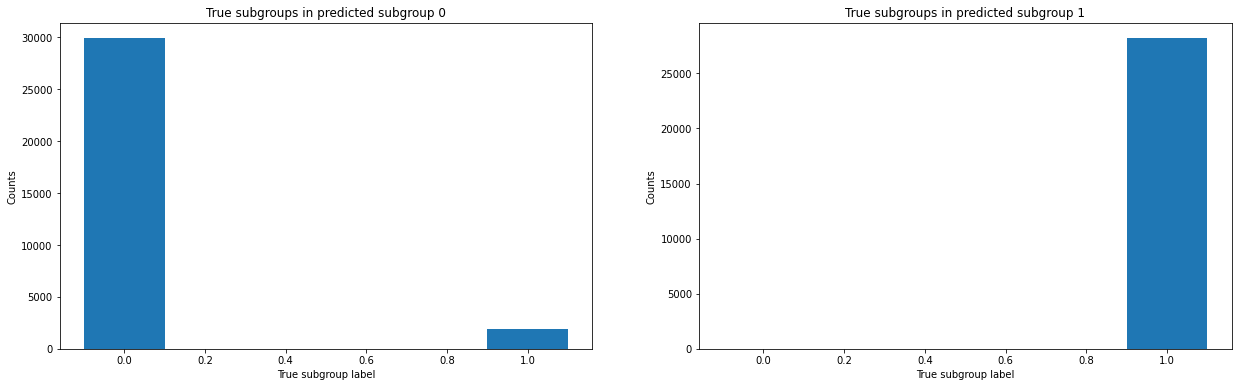

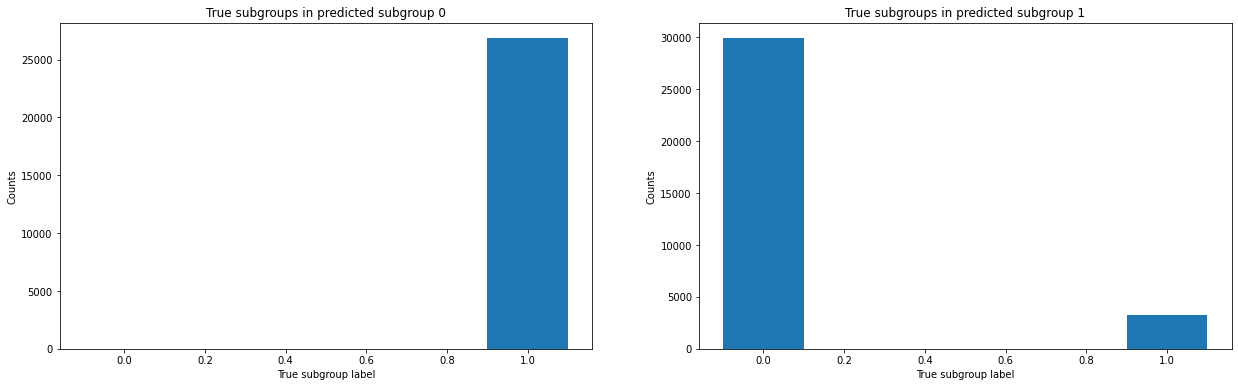

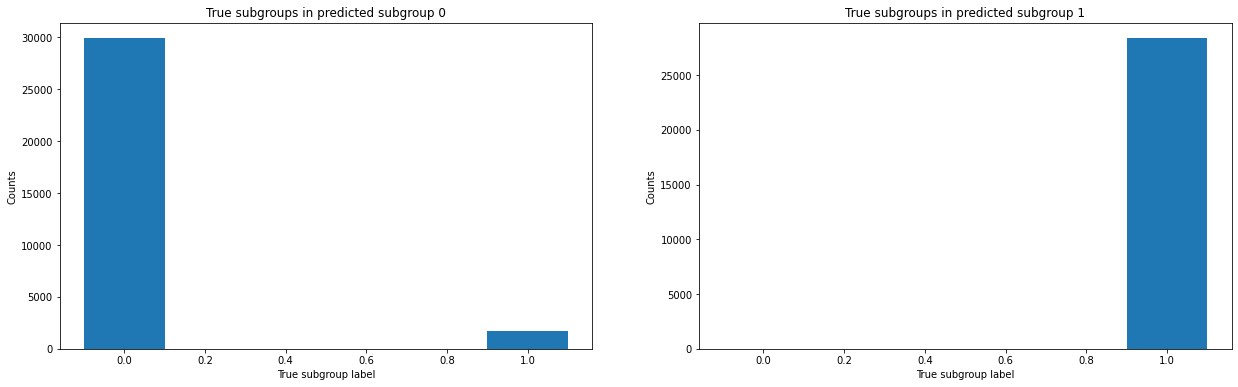

In [131]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cfmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=False)

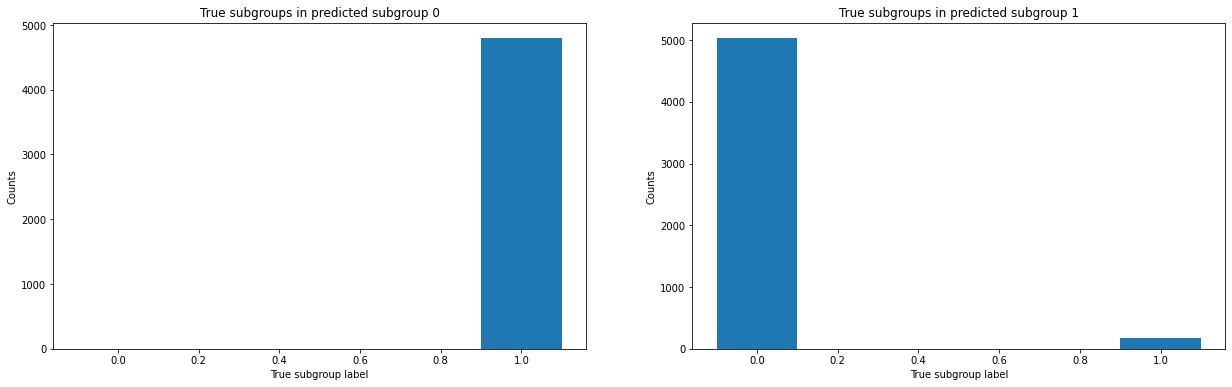

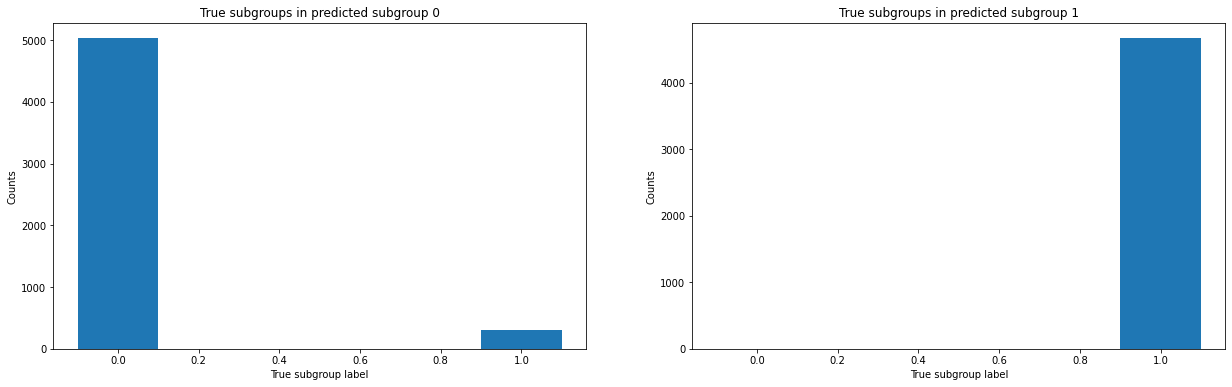

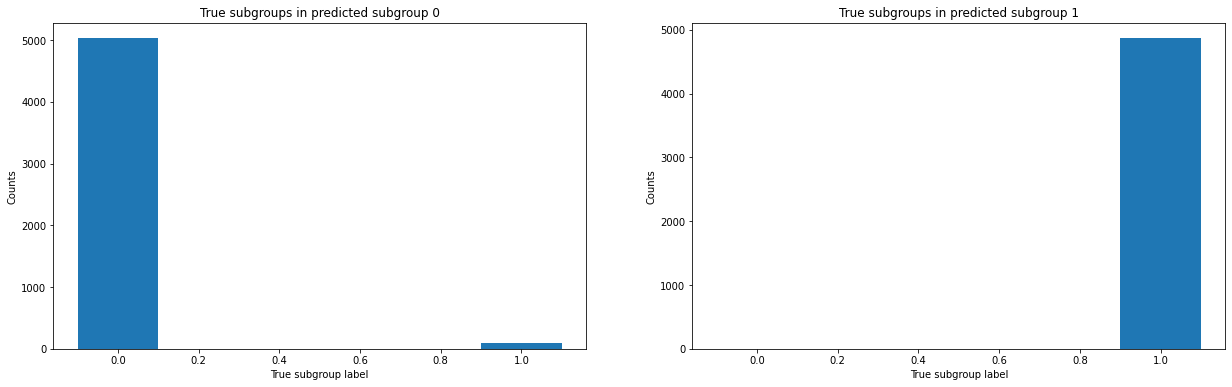

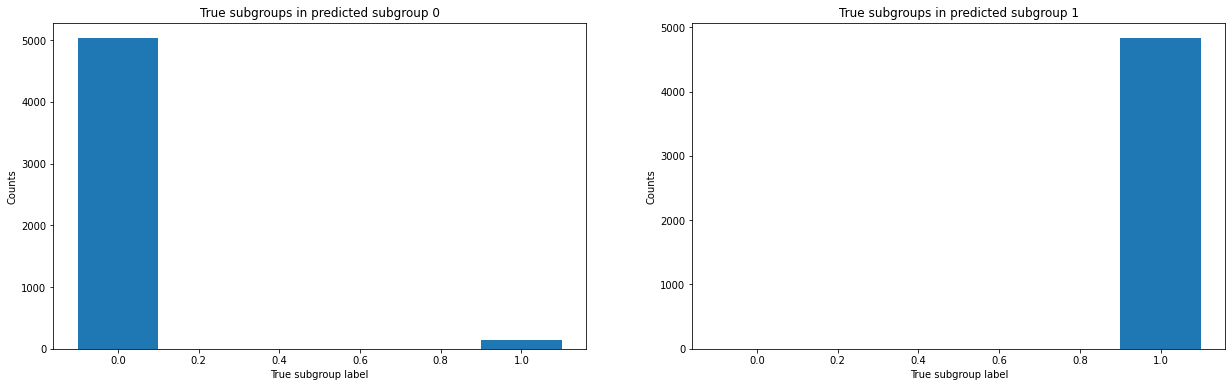

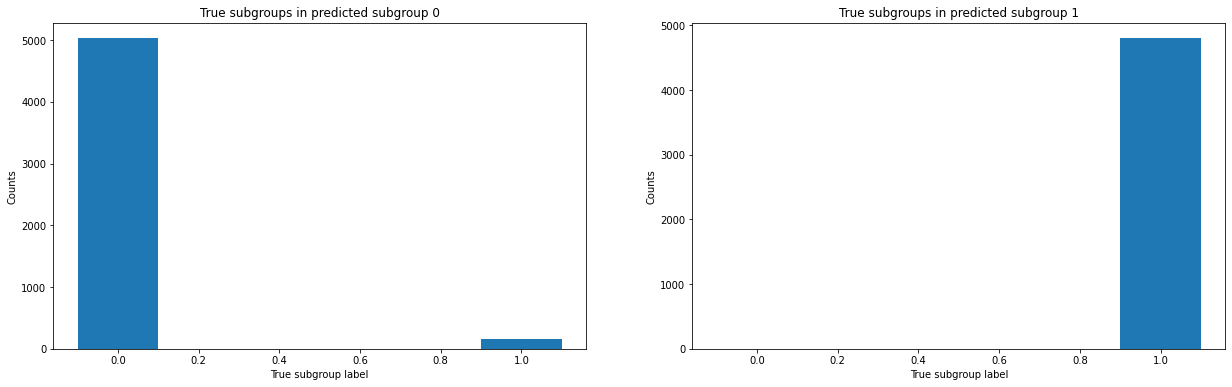

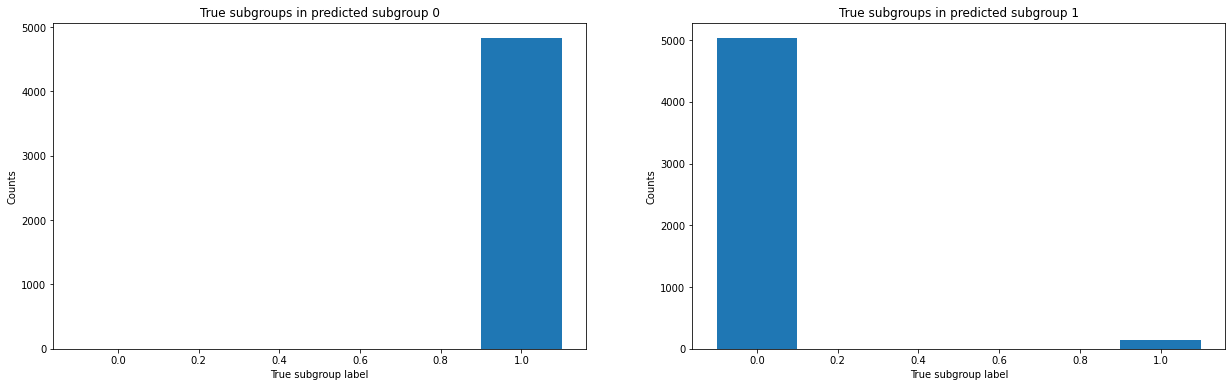

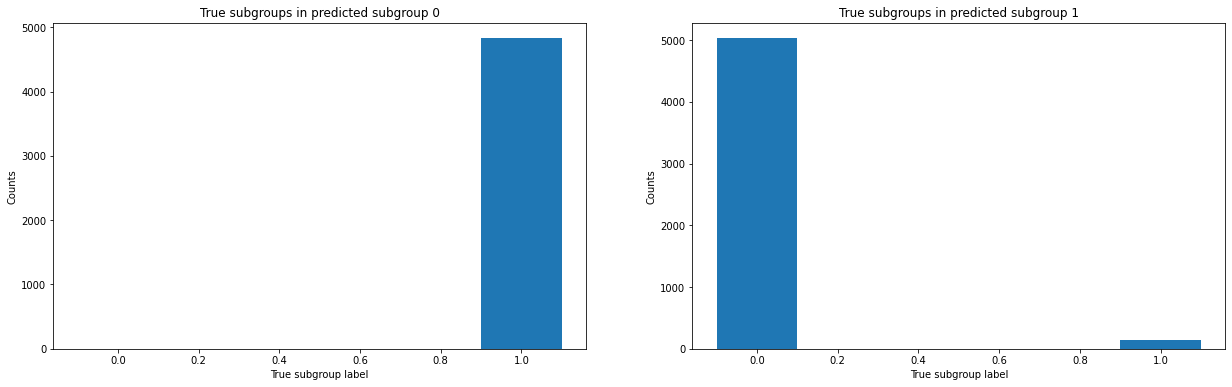

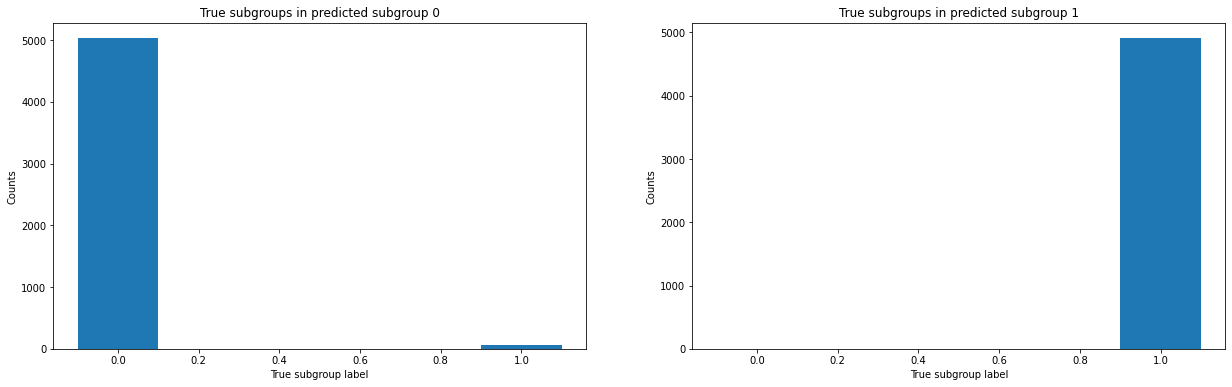

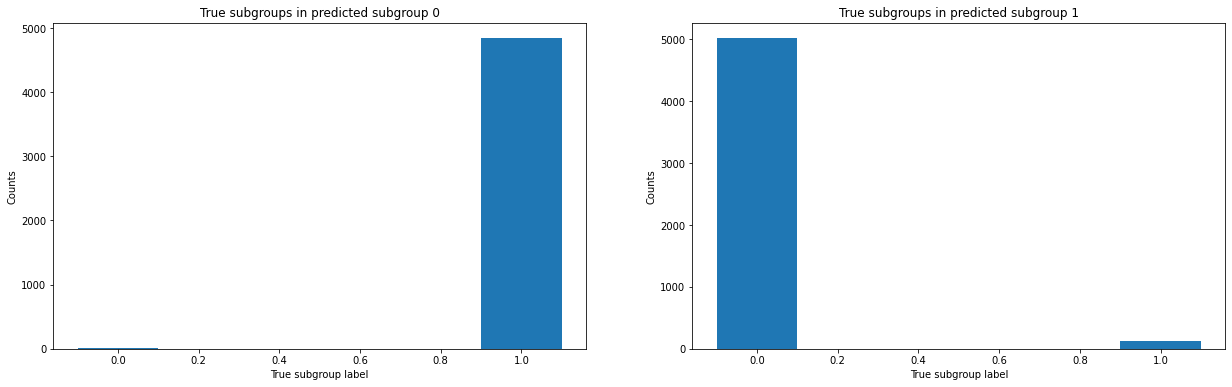

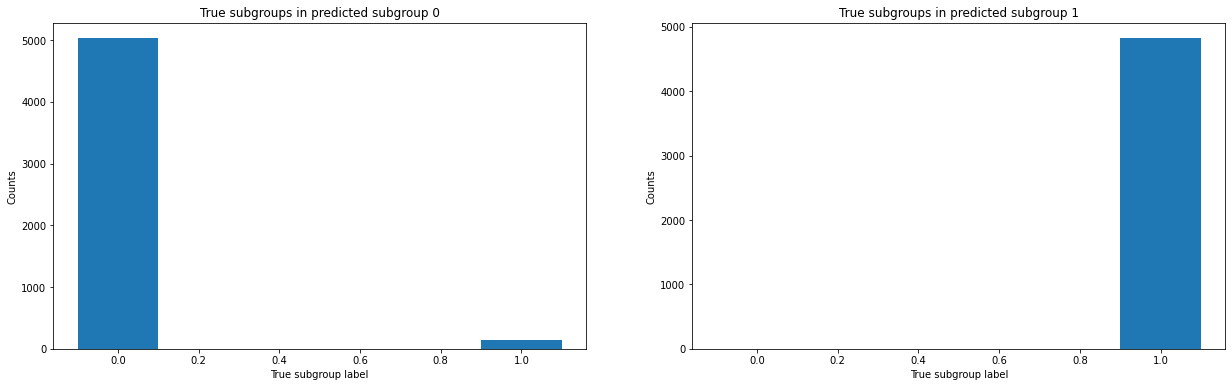

In [132]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cfmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)